In [1]:
'''
things to check

1. frequency of clusters
2. cluster transitions matrix
3. do people come back to previous clusters?
4. depths per cluster
5. 
'''

'\nthings to check\n\n1. frequency of clusters\n2. cluster transitions matrix\n3. do people come back to previous clusters?\n4. depths per cluster\n5. \n'

In [2]:
import pandas as pd
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import FancyArrowPatch
from IPython.display import HTML
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from matplotlib.cm import get_cmap
import seaborn as sns
from matplotlib.patches import Circle
import scipy.stats as stats

/Users/snath/Nextcloud/Documents/PhD/Code/projects/process_modelling/process_modelling/.env_process_modelling/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
# def plot_hist(arr, xlabel, ylabel, ax):
#     ax.hist(arr, color="#d3c6f5")
#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel)

def get_sentence_transformer_embeddings(texts):
    """Extracts Text Embeddings using SentenceTransformer (model: gte-large)
    Args:
        texts (list): List of texts
    Returns:
        dict: Text and corresponding embedding
    """
    model = SentenceTransformer('thenlper/gte-large')
    embeddings = model.encode(texts)
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)         # normalise embeddings
    return dict(zip(texts, embeddings))

# def get_clusters(embeddings, texts, cluster_assignment, printclusters):
#     """Helper function for perform_hierarchicalClustering()
#     Args:
#         embeddings (list): List of embeddings
#         texts (list): List of texts
#         cluster_assignment (list): cluster assignment for each text/embedding
#         printcluster (bool): True will print all texts in each cluster
#     Returns:
#         response_to_cluster dict: text to cluster number
#         cluster_to_response dict: cluster number to list of texts in that cluster
#         num_clusters int: number of clusters
#         min_similarities dict: cluster to min text similiarity
#     """

#     cluster_to_response = defaultdict(list)                                 # make cluster_to_response
#     cluster_to_embeddings = defaultdict(list)                               # make cluster_to_embeddings (used for min sim)
#     for ind, cluster_num in enumerate(cluster_assignment):
#         cluster_to_response[cluster_num].append(texts[ind])
#         cluster_to_embeddings[cluster_num].append(embeddings[ind])
    
#     response_to_cluster = dict(zip(texts, cluster_assignment))              # make response_to_cluster 
    
#     num_clusters = len(np.unique(cluster_assignment))                       # find num clusters

#     min_similarities = {}                                                   # find min paiwise text similarity in each cluster
#     for cl in cluster_to_embeddings:
#         stacked = np.array(cluster_to_embeddings[cl])
#         sim = stacked @ stacked.T
#         np.fill_diagonal(sim, np.inf)
#         min_sim = np.min(sim)
#         min_similarities[cl] = min_sim
    
#     if printclusters:                                                       # print clusters if True
#         for cluster_num, responses in cluster_to_response.items():
#             print(f"Cluster {cluster_num}")
#             print(responses, end="\n\n")

#     return response_to_cluster, cluster_to_response, num_clusters, min_similarities

# def perform_hierarchicalClustering(embeddings, texts, ax, cut_off_distance, printclusters):
#     """Performs hierarchical clustering
#     Args:
#         embeddings (list): List of embeddings
#         texts (list): List of texts
#         ax: axes for plotting
#         cut_off_distance (float): distance threshold for hierarchical clustering
#         printcluster (bool): True will print all texts in each cluster
#     Calls:
#         get_clusters()
#     """
#     linked = linkage(embeddings, 'ward')                                                                                                    # 'ward' distance for measuring distance between clusters
#     dendrogram(linked, orientation='top', labels=texts, distance_sort='descending', show_leaf_counts=False, no_labels=True, ax=ax[0])       # Make dendogram
    
#     # Elbow plot -- Plot mean minsim/number of clusters as a fn of cut-off distance
#     mean_minsemsim = []
#     num_clusters = []
#     for cod in np.linspace(1, 8, 30):
#         cluster_assignment = fcluster(linked, t=cod, criterion='distance')
#         _, _, _, minsims = get_clusters(embeddings, texts, cluster_assignment, False)
#         mean_minsemsim.append(np.mean(list(minsims.values())))
#         num_clusters.append(len(np.unique(cluster_assignment)))
#     ax[1].plot(np.linspace(1, 8, 30), mean_minsemsim)
#     ax[1].set_xlabel("Cut-off distance"); ax[1].set_ylabel("Mean cluster semantic similarity")
#     ax[2].plot(np.linspace(1, 8, 30), num_clusters)
#     ax[2].set_xlabel("Cut-off distance"); ax[2].set_ylabel("Number of clusters")

#     cluster_assignment = fcluster(linked, t=cut_off_distance, criterion='distance')         # assign clusters using the decided cut_off_distance
#     return get_clusters(embeddings, texts, cluster_assignment, printclusters)

def calculate_cosine_similarity(embedding1, embedding2):
    """Calculates cosine similarity between two embeddings
    Args:
        embedding1: first embedding
        embedding2: second embedding
    Returns:
        cosine similarity
    """
    if np.any(embedding1) and np.any(embedding2):
        return np.dot(embedding1, embedding2)
    else:
        return 0

def plot_movement(cluster_order, pid, ax, num_clusters, marker_sizes):
    # Calculate the positions of the equidistant points on the circle
    theta = np.linspace(0, 2 * np.pi, num_clusters, endpoint=False)
    x = 1.5 * np.cos(theta)
    y = 1.5 * np.sin(theta)

    # Adjust the cluster_order to be zero-indexed
    cluster_order = [p-1 for p in cluster_order]

    # Create the figure and axis
    ax.set_aspect('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.axis('off')

    # Annotate the points with their numbers
    for i in range(num_clusters):
        ax.text(x[i], y[i], str(i + 1), fontsize=12, ha='center', va='center', c="r")

    # Define a colormap
    cmap = plt.get_cmap('viridis')

    # Draw lines and arrows
    for i in range(len(cluster_order) - 1):
        start = (x[cluster_order[i]], y[cluster_order[i]])
        end = (x[cluster_order[i + 1]], y[cluster_order[i + 1]])
        
        # Get the color from the colormap
        color = cmap(i / (len(cluster_order) - 1))
        if start[0] == end[0] and start[1] == end[1]:

            start_tuple = (start[0], start[1])
            if start_tuple not in marker_sizes:
                marker_sizes[start_tuple] = 10  # Initialize the marker size for this point

            ax.plot(start[0], start[1], 'o', c="black", markersize=marker_sizes[start_tuple], clip_on=False)
            marker_sizes[start_tuple] += 1
            continue
        
        # Draw the line with the assigned color
        ax.plot([start[0], end[0]], [start[1], end[1]], color=color)
        
        # Calculate the midpoint for the arrow
        mid = ((start[0] + end[0]) / 2, (start[1] + end[1]) / 2)
        direction = (end[0] - start[0], end[1] - start[1])
        length = np.hypot(direction[0], direction[1])
        direction = (direction[0] / length, direction[1] / length)
        
        # Draw the arrow at the midpoint
        arrow = FancyArrowPatch((mid[0] - direction[0] * 0.15, mid[1] - direction[1] * 0.15),
                                (mid[0] + direction[0] * 0.15, mid[1] + direction[1] * 0.15),
                                color=color, arrowstyle='-|>', mutation_scale=15)
        ax.add_patch(arrow)

    # Show the final static image
    ax.set_title(f"\nParticipant {pid}\n")

In [4]:
# cluster_to_animals = {
#     1: ["aardvark", "ankole", "antelope", "aoudad", "blesbok", "bontebok", "buffalo", "bushbaby", "bushbuck", "bushpig", "camel", "caracal", "chameleon", "cheetah", "chimpanzee", "civet", "cliffchat", "cobra", "colobus", "cusimanse", "dassie", "dikdik","duiker", "eland", "elephant", "fennecfox", "gazelle", "gemsbok", "genet", "gerenuk", "giraffe", "gnu", "gorilla", "hartebeest", "hippopotamus", "hyena", "hyrax", "impala", "jackal", "jerboa", "klipspringer", "kob", "kongoni", "koodoo", "kudu", "lechwe", "lemur", "leopard", "lion", "lioness", "lourie", "lovebird", "manatee", "mandrill", "meerkat", "mongoose", "monkey", "mousebird", "nyala", "okapi", "oribi", "oryx", "ostrich", "panther", "puku", "quagga", "reedbuck", "rhino", "rhinoceros", "serval", "sifaka", "springbok", "springhare", "steenbok", "steenbuck", "sunbird", "sungazer", "suricate", "tiger", "topi", "tsessebe", "warthog", "waterbuck", "wildebeest", "zebra", "zorilla"],
#     2: ["alpaca", "beaver", "chamois", "chinchilla", "ermine", "fox", "llama", "mink", "rabbit", "sable", "vicuna"],
#     3: ["arcticfox", "auk", "caribou", "muskox", "penguin", "polarbear", "reindeer", "seal", "sheathbill", "walrus", "woollymammoth"],
#     4: ["bandicoot", "corella", "devil", "dingo", "duckbill", "dunnart", "emu", "galah", "kangaroo", "kiwi", "koala", "macropod", "malleefowl", "numbat", "pademelon", "platypus", "opossum", "possum", "potoroo", "quoll", "sugar", "sugarglider", "tasmaniandevil", "wallaby", "wallaroo", "wambenger", "wombat", "woylie"],
#     5: ["ass", "burro", "camel", "colt", "donkey", "dromedary", "horse", "llama", "mare", "mule", "mustang", "ox", "pony", "trotter", "yak"],
#     6: ["albatross", "avian", "avocet", "bird", "bittern", "blackbird", "bluebird", "bluefootedbooby", "bluegill", "bluejay", "bobolink", "booby", "boubou", "bulbul", "bullfinch", "bunting", "Bustard", "buzzard", "canary", "cardinal", "cassowary", "chickadee", "chicken", "cliffchat", "cock", "cockatiel", "cockatoo", "conure", "corella", "cormorant", "crake", "crow", "cuckoo", "curassow", "dabchick", "darter", "dikkop", "dodo", "dove", "drake", "duck", "duckling", "eagle", "eaglet", "egret", "emu", "ewe", "falcon", "finch", "flamingo", "fowl", "francolin", "frogmouth", "galah", "gallinule", "gander", "goldfinch", "gonolek", "goshawk", "gosling", "grebe", "greenfinch", "grosbeak", "grouse", "guineafowl", "gull", "gyrfalcon", "hammerkop", "harrier", "hawk", "heron", "honeyeater", "hornbill", "hummingbird", "ibis", "jackdaw", "jay", "kestrel", "kingfisher", "kite", "kiwi", "kookaburra", "lark", "laughingthrush", "loon", "lorikeet", "lory", "lourie", "lovebird", "macaw", "magpie", "mallard", "malleefowl", "marshbird", "meadowlark", "merganser", "merlin", "mockingbird", "moorhen", "motmot", "mouse", "mousebird", "myna", "nightingale", "openbill", "oriole", "osprey", "ostrich", "owl", "parakeet", "parrot", "partridge", "peacock", "peafowl", "pelican", "penguin", "peregrine", "pheasant", "pigeon", "pintail", "pitta", "plover", "puffin", "quail", "quetzal", "rail", "raven", "rhea", "roadrunner", "robin", "rook", "sandgrouse", "sandpiper", "seagull", "seriema", "sheathbill", "shelduck", "shoveler", "shrike", "siskin", "skylark", "snipe", "songbird", "sparrow", "spoonbill", "spurfowl", "starling", "stilt", "stork", "sunbird", "sunbittern", "swallow", "swallowtail", "swan", "swift", "tanager", "teal", "thrush", "tinamou", "titmouse", "toucan", "tragopan", "trumpeter", "turaco", "turkey", "umbrellabird", "vulture", "warbler", "waxbill", "weaver", "wigeon", "wildfowl", "woodpecker", "wren"],
#     7: ["ankole", "antilope", "aoudad", "bison", "blesbok", "bontebok", "buffalo", "bullock", "bushbock", "calf", "cattle", "cow", "dik dik", "gemsbok", "gerenuk", "hartebeest", "heifer", "ibex", "klipspringer", "kob", "monitor", "muskox", "nilgai", "nyala", "oribi", "pronghorn", "puku", "reedbuck", "springbok", "steenbuck", "steer", "topi", "tsessebe", "water buffalo", "waterbuck", "yak", "zebu"],
#     8: ["akita", "barbet", "blacklab", "bloodhound", "bulldog", "canine", "chihuahua", "coati", "coatimundi", "coyote", "dachshund", "dalmatian", "dog", "fox", "golden retriever", "great dane", "greyhound", "grison", "harrier", "husky", "hyena", "jackal", "labrador retriever", "malamute", "pembroke welsh corgi", "poodle", "pug", "puggle", "pup", "shihtzu", "siberian husky", "terrier", "timber wolf", "wild dog", "wolf"],
#     9: ["blacktailed deer", "brocket", "buck", "caribou", "chital", "deer", "doe", "eland", "elk", "fawn", "gazelle", "gnu", "impala", "moose", "muledeer", "muntjac", "reindeer", "roe", "sambar", "stag", "wapiti", "whitetailed deer", "wildebeest"],
#     10: ["ass", "billygoat", "bronco", "bullock", "calf", "chick", "chicken", "cock", "colt", "cow", "donkey", "ferret", "foal", "goat", "heifer", "hen", "hog", "horse", "kid", "lamb", "mare", "miniature pony", "mule", "pig", "piglet", "pony", "potbellied pig", "ram", "rabbit", "rooster", "sheep", "snake", "sow", "spider", "stallion", "turkey"],
#     11: ["bengal tiger", "bobcat", "bull", "cat", "caracal", "cheetah", "civet", "cougar", "crane", "jaguar", "jaguarundi", "leopard", "leopardess", "liger", "lion", "lynx", "margay", "mountainlion", "ocelot", "panther", "puma", "ring tailed cat", "serval", "siamese cat", "snow leopard", "snow lion", "tiger", "tigress", "tomcat", "whitetiger", "wildcat"],
#     12: ["fisher", "angelfish", "arrowheadshark", "balloonfish", "barracuda", "bass", "betta", "blacktipreefshark", "blowfish", "carp", "catfish", "cavefish", "cichlids", "clownfish", "cuttlefish", "dragonet", "filefish", "fish", "flounder", "freshwater fish", "goldfish", "great white shark", "grenadier", "grouper", "grunt", "guppy", "herring", "jack", "knifefish", "koi", "lamprey", "lionfish", "lookdown", "mackerel", "mako shark", "minnow", "moray", "pacu", "parrotfish", "pike", "pink salmon", "piranha", "pleco", "porkfish", "pufferfish", "rainbowfish", "sailfish", "salmon", "saltwater fish", "scorpionfish", "seabass", "shark", "shrimp", "smelt", "stickleback", "stonefish", "sturgeon", "swordfish", "tang", "tetra", "tilapia", "triplefin", "trout", "tuna", "whale shark"],
#     13: ["aardvark", "anteater", "armadillo", "bat", "bittern", "echidna", "hedgehog", "jumpingspider", "mole", "shrew", "spiderling", "sugar"],    
#     14: ["ant", "antlion", "aphid", "bee", "beetle", "blackwidow", "bug", "butterfly", "caterpillar", "centipede", "cicada", "cockroach", "cricket", "daddy long legs", "dragonfly", "earthworm", "flea", "fly", "gnat", "grasshopper", "grub", "honeybee", "hornet", "insect", "June beetle", "ladybug", "larva", "leafy", "louse", "lubber", "maggot", "mealworm", "mite", "monarch butterfly", "mosquito", "moth", "pill bug", "praying mantis", "scorpion", "silkworm", "stick insect", "tarantula", "termite", "tick", "wasp", "worm", "yellow jacket"],
#     15: ["antelope", "badger", "bear", "beaver", "bighorn", "bighorn", "bison", "blackbear", "boar", "bobcat", "brownbear", "caribou", "chipmunk", "chuckwalla", "cornsnake", "cottonmouth", "cougar", "coyote", "cub", "deer", "drongo", "elk", "fox", "grizzly bear", "kodiak bear", "moose", "mountaingoat", "mountainlion", "pronghorn", "puma", "rabbit", "raccoon", "skunk", "squirrel", "titmouse", "vaquita", "weasel", "wolf"],
#     16: ["budgie", "canary", "cat", "cockatiel", "cockatoo", "dog", "gerbil", "goldenretriever", "goldfish", "guineapig", "guppy", "hamster", "kitten", "labradorretriever", "malamute", "parakeet", "parrot", "poodle", "puppy", "rabbit"],
#     17: ["ape", "baboon", "bonobo", "capuchin", "chimpanzee", "colobus", "gibbon", "gorilla", "howler monkey", "human", "langur", "lemur", "loris", "macaque", "mandrill", "marmoset", "monkey", "orangutan", "primates", "saki monkey", "shrew", "siamang", "sifaka", "snow monkey", "spider monkey", "tamarin", "titi"],
#     18: ["bunny", "coney", "hare", "jackrabbit", "rabbit"],
#     19: ["adder", "alligator", "amphibian", "anaconda", "anole", "asp", "basilisk", "black mamba", "boaconstrictor", "bullfrog", "caiman", "chameleon", "chuckwalla", "cobra", "constrictor", "cornsnake", "cottonmouth", "crocodile", "diamondback", "dinosaur", "dragon", "frog", "garden snake", "gecko", "godzilla", "iguana", "kingsnake", "komododragon", "lizard", "milksnake", "moccasin", "newt", "pit viper", "python", "ratsnake", "rattlesnake", "reptile", "salamander", "serpent", "sidewinder", "skink", "snake", "sungazer", "toad", "tomistoma", "tortoise", "tree frog", "turtle", "velociraptor", "viper", "watersnake"],
#     20: ["agouti", "beaver", "blacksquirrel", "capybara", "cavy", "chinchilla", "chipmunk", "degu", "dormouse", "flyingsquirrel", "gerbil", "goldenmarmot", "gopher", "groundhog", "guineapig", "hamster", "hedgehog", "lemming", "marmot", "mole", "mouse", "muskrat", "naked mole rat", "phascogale", "porcupine", "potoroo", "prairie dog", "rat", "rodent", "shrew", "springhare", "squirrel", "vole", "woodchuck", "woylie"],
#     21: ["alga", "alligator", "anemone", "axolotl", "baiji", "balloonfish", "beaver", "beluga", "blacktipreefshark", "bluewhale", "boto", "brineshrimp", "cavefish", "cichlids", "clam", "conch", "coral", "cowry", "crab", "crawfish", "crayfish", "dogfish", "dolphin", "dragonet", "dugong", "eel", "elephant seal", "filefish", "fish", "frog", "goose", "hammerhead shark", "humpback whale", "jellyfish", "killer whale", "knifefish", "leech", "limpet", "lionfish", "lobster", "lookdown", "manatee", "mantaray", "moray", "murex", "muskrat", "mussel", "narwhal", "nautilus", "newt", "octopus", "orca", "otter", "oyster", "pacu", "penguin", "platypus", "pleco", "porkfish", "porpoise", "prawn", "pufferfish", "ray", "sailfish", "salamander", "sanddollar", "sawfish", "scallop", "scorpionfish", "sealion", "seamonkey", "seahorse", "seal", "shark", "slug", "snail", "sponge", "squid", "starfish", "stingray", "stonefish", "tadpole", "tang", "tetra", "toad", "triplefin", "turtle", "urchin", "vaquita", "whale"],
#     22: ["badger", "ferret", "groundhog", "marten", "mink", "mongoose", "otter", "polecat", "seaotter", "skunk", "stoat", "weasel", "wolverine"]
# }

# animal_to_clusters = {}
# for key, value_list in cluster_to_animals.items():
#     for value in value_list:
#         if value not in animal_to_clusters:
#             animal_to_clusters[value] = [key]
#         else:
#             animal_to_clusters[value].append(key)

In [5]:
# df = pd.read_csv("../csvs/data.csv")
# df["pid"] = pd.factorize(df['sid'])[0]
# df["clusters"] = df["entry"].map(animal_to_clusters)
# df['previous_entry'] = df['entry'].shift(1)
# df["order"] = np.concatenate([np.arange(i) for i in df.groupby("pid").count()["entry"].tolist()])    # order variable per ppt x task. Starts from 0
# df.loc[df["order"] == 0, "previous_entry"] = None

In [6]:
# animals = df["entry"].unique().tolist()
# filename = "sentence_transformer_embeddings_animals_gtelarge"
# try:
#     sentence_transformer_embeddings = pk.load(open(f"../embeddings/{filename}.pk", "rb"))
# except:
#     sentence_transformer_embeddings = get_sentence_transformer_embeddings(animals)
#     pk.dump(sentence_transformer_embeddings, open(f"../embeddings/{filename}.pk", "wb"))

In [7]:
# num_categories = 22
# num_participants = len(df["sid"].unique())

## Statistics

In [8]:
# fig, ax = plt.subplots(1,3, figsize=(10,3))
# plot_hist(df.groupby("pid").count()["entry"], "Number of Responses", "Number of Participants", ax[0])
# plot_hist(df.groupby("pid").sum()["flastitem"].to_numpy()/df.groupby("pid").count()["entry"].to_numpy(), "Percentage Jumps", "Number of Participants",  ax[1])

# def mean_depth(group):
#     reset_points = list(group[group['fpatchitem'] == 1].index) + [int(group.index[-1]) + 1]
#     segment_lengths = np.array(pd.Series(reset_points).diff().tolist()[1:])
#     return segment_lengths.mean()
# plot_hist(df.groupby('pid').apply(mean_depth).tolist(), "Mean Depth", "Number of Participants",  ax[2]);
# plt.tight_layout()

In [9]:
# df[df["clusters"].isnull()]

In [10]:
# fig, ax = plt.subplots(1, 3, figsize=(25, 5))
# response_to_cluster, cluster_to_response, num_clusters, minsim = perform_hierarchicalClustering([sentence_transformer_embeddings[x] for x in animals], animals, ax, 1, True)
# print("Num clusters =", num_clusters)
# print(np.min(list(minsim.values())), np.mean(list(minsim.values())))

In [11]:
# def write_category_SS_jump_filterorder0(data):
#     # write category using response_to_cluster
#     data["category"] = data["entry"].apply(lambda x: response_to_cluster.get(x))

#     data['SS'] = data.apply(lambda row: calculate_cosine_similarity(sentence_transformer_embeddings.get(row['entry']), sentence_transformer_embeddings.get(row['previous_entry'])), axis=1)
    
#     data["category"] = data["category"].astype(int)
#     data["jump_cat"] = (~(data["category"].diff() == 0)).astype(int)
#     data["jump_SS"] = (data["SS"] < 0.81).astype(int)
#     # data['jump'] = data["jump_cat"] & data["jump_SS"]
#     data['jump'] = data["jump_cat"]


#     data = data[data["order"] > 0]      # remove the first response

#     return data

# df = write_category_SS_jump_filterorder0(df)

In [12]:
# fig, ax = plt.subplots(10, 3, figsize=(13,40))
# for pid in range(30):
#     plot_movement(df[df["pid"] == pid]["category"].tolist(), pid, ax[pid//3, pid%3])
# plt.tight_layout()
# plt.show()

# Load data

In [13]:
data_humans = pd.read_csv("../csvs/data_humans_allresponses.csv")
data_humans = data_humans.drop(columns = ["Unnamed: 0"])

cluster_to_response_autbrick = pk.load(open("../pickle/cluster_to_response_autbrick.pk", 'rb'))
num_clusters_autbrick = len(cluster_to_response_autbrick)
sentence_transformer_embeddings_autbrick = pk.load(open("../embeddings/sentence_transformer_embeddings_autbrick_gtelarge.pk", 'rb'))
cluster_to_response_autpaperclip = pk.load(open("../pickle/cluster_to_response_autpaperclip.pk", 'rb'))
num_clusters_autpaperclip = len(cluster_to_response_autpaperclip)
sentence_transformer_embeddings_autpaperclip = pk.load(open("../embeddings/sentence_transformer_embeddings_autpaperclip_gtelarge.pk", 'rb'))
cluster_to_response_vf = pk.load(open("../pickle/cluster_to_response_vf.pk", 'rb'))
num_clusters_vf = len(cluster_to_response_vf)
sentence_transformer_embeddings_vf = pk.load(open("../embeddings/sentence_transformer_embeddings_vf_gtelarge.pk", 'rb'))

# Add columns

In [15]:
# Calculate think times

data_humans["response_length"] = data_humans["original_response_Dutch"].str.len()

grouped = data_humans.groupby('pid')

def calculate_slope(group):
    RT = group['RT'].values
    length = group['response_length'].values
    slope, intercept = np.polyfit(RT, length, 1)
    return slope

data_humans['slope'] = data_humans['pid'].map(grouped.apply(calculate_slope))
data_humans["RT_think"] = data_humans["RT"] - data_humans["response_len"] * data_humans['slope']
data_humans["RT_think_transformed"] = data_humans.groupby(["pid", "task"])["RT_think"].transform(lambda x: x - x.min())

(0.0, 40.0)

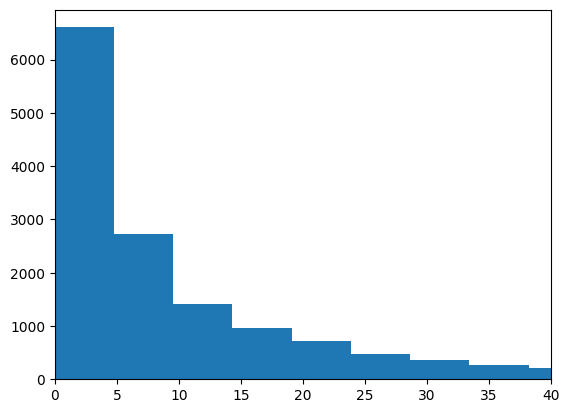

In [16]:
plt.hist(data_humans["RT_think_transformed"], bins=100)
plt.xlim(0,40)

In [17]:
# wherever sim caused stay, take previous clister as the cluster

data_humans["category_simaccounted"] = data_humans["category"]

grouped = data_humans.groupby(["task", "pid"])

def apply_ffill(group):
    group = group.reset_index(drop=True)
    for i in range(1, len(group)):
        if group['jump'].iloc[i] == 0:
            group['category_simaccounted'].iloc[i] = group['category_simaccounted'].iloc[i-1]
    return group

data_humans = grouped.apply(apply_ffill).reset_index(drop=True)

In [19]:
# data_humans.loc[data_humans["task"] == 2, 'SS_ref'] = data_humans[data_humans["task"] == 2].apply(lambda row: calculate_cosine_similarity(sentence_transformer_embeddings_autbrick.get(row['response']), embeddings_ref_aut.get("brick")), axis=1)
# data_humans.loc[data_humans["task"] == 3, 'SS_ref'] = data_humans[data_humans["task"] == 3].apply(lambda row: calculate_cosine_similarity(sentence_transformer_embeddings_autpaperclip.get(row['response']), embeddings_ref_aut.get("paperclip")), axis=1)
# data_humans.loc[data_humans["task"] == 1, 'SS_ref'] = data_humans[data_humans["task"] == 1].apply(lambda row: calculate_cosine_similarity(sentence_transformer_embeddings_vf.get(row['response']), embeddings_ref_vf.get("animal")), axis=1)

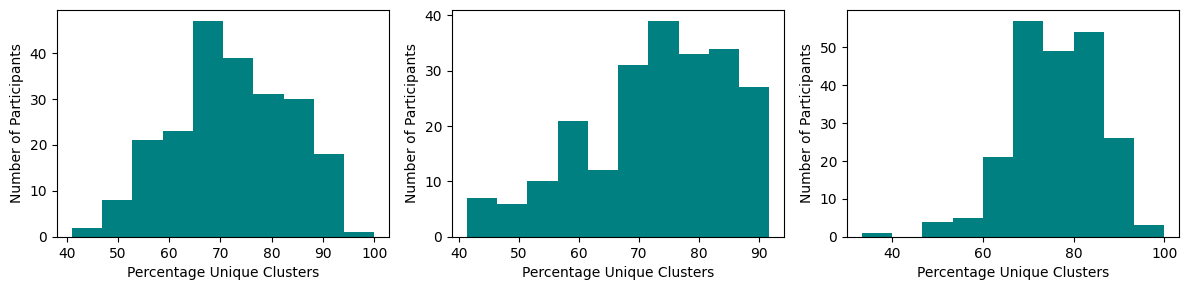

In [20]:
# Percent unique clusters

fig, ax = plt.subplots(1, 3, figsize=(12,3))
ax[0].hist(data_humans[data_humans["task"] == 2][["pid", "category_simaccounted", "jump"]].groupby("pid").nunique()["category_simaccounted"].values / (data_humans[data_humans["task"] == 2][["pid", "category_simaccounted", "jump"]].groupby("pid").sum()["jump"].values + 1) * 100, color="teal")
ax[0].set_xlabel("Percentage Unique Clusters")
ax[0].set_ylabel("Number of Participants");

ax[1].hist(data_humans[data_humans["task"] == 3][["pid", "category_simaccounted", "jump"]].groupby("pid").nunique()["category_simaccounted"] / (data_humans[data_humans["task"] == 3][["pid", "category_simaccounted", "jump"]].groupby("pid").sum()["jump"] + 1) * 100, color="teal")
ax[1].set_xlabel("Percentage Unique Clusters")
ax[1].set_ylabel("Number of Participants");

ax[2].hist(data_humans[data_humans["task"] == 1][["pid", "category_simaccounted", "jump"]].groupby("pid").nunique()["category_simaccounted"] / (data_humans[data_humans["task"] == 1][["pid", "category_simaccounted", "jump"]].groupby("pid").sum()["jump"] + 1) * 100, color="teal")
ax[2].set_xlabel("Percentage Unique Clusters")
ax[2].set_ylabel("Number of Participants");
plt.tight_layout()

In [21]:
# Examine the clusters

# k = 32
# print(len(cluster_to_response_autbrick[k]))
# cluster_to_response_autbrick[k]

# AUT brick -
# 1: "47: oven, pizza, heating - good"
# 2: "52: heating, cooling - good"
# 3: "36: fireplace, chimney, hearth - good"
# 4: "76: barbeque, grill, campfire - good"
# 5: "119: house, roof, building, apartment - good"
# 6: "54: brickyard, block, brickandmortar - good but confounded with toy"
# 7: "63: rain, dam , pond, water - good"
# 8: "69: animal shelter, weapon against animals - good all about animals but may mean different things"
# 9: "87: fences, demarcation, barrier, shielding, wall - ok, some other random ones, confounded with cover"
# 10: "116: household furniture - doorstopper, shelf, bottle, bookend, bookshelf, closet - not too good"
# 11: "74: plants, flowers, vase, pot - good"
# 12: "46: street, sidewalk, pathway, road - good"
# 13: "120: path, outdoor, patio, garden - not so good"
# 14: "54: exercise weight, lifting, training weight - good"
# 15: "121: "weight other, anchor - okay"
# 16: "81: "throw, ball, game - confounded with game"
# 17: "31: everything paper - good"
# 18: "93: game, toy, puzzle, personify - good"
# 19: "45: break, smash, throw, window - okay"
# 20: "98: fight, kill, injury, murder, weapon, throw in anger - goodish"
# 21: "164: "smash, grind, crack, press, crush - quite noisy, not so good"
# 22: "89: decoration, ornaments, art - some noise, mostly okay"
# 23: "68: art, painting, colour - good"
# 24: "104: "stool, elevation, support, stairs - good"
# 25: "110: furniture, raise leg, table, bench, chair - okayish" 
# 26: "89: very noisy"
# 27: "244: very noisy"
# 28: "85: engrave, mark, draw, scratch, write - noisy"
# 29: "55: stones, pebbles, statue, scultpure"
# 30: "390: very noisy" 
# 31: "81: base, holder, stand - noisy"
# 32: "120: noisy"

In [78]:
k = 16
print(len(cluster_to_response_autpaperclip[k]))
cluster_to_response_autpaperclip[k]

# 1: "124: marker, write - noisy"
# 2: "171: binder, holder - okayish"
# 3: "82: has word clip or paper clip - bad cluster"
# 4: "99: together, bind, connect - good"
# 5: "71: scratch, itch - good"
# 6: "51: nail of both meanings - good"
# 7: "48: glasses, eye glass - good"
# 8: "57: device reset, button - confouned with button of reset button and shirt button"
# 9: "231: very noisy"
# 10: "47: thread and needle - good"
# 11: "107: poke, prick, puncture, pop, make holes - good"
# 12: "179: art, scultpure, shapes, paint, carve, write - good"
# 13: "32: magnetic property - good"
# 14: "52: fishing, hook - good"
# 15: "45: guitar, instrument, music - good"
# 16: "138: food, kitchen - okqyish"
# 17: "716: very noisy"
# 18: "95: unlock, lock pick - good"
# 19: "58: key, keyboard, piano keys - noisy"
# 20: "80: zip - good"
# 21: "145: seal, close, opener - confounded close and open"
# 22: "85: jewelry - good"
# 23: "77: ear related: earring, headphones, earwax, piercing - good"
# 24: "92: photo hanger, frame - good"
# 25: "90: ornament, christmas, decoration - okayish"
# 26: "55: plant, flowers - good"
# 27: "76: hair related, head - good"
# 28: "132: clothes, fabric - good"
# 29: "343: very noisy"
# 30: "108: chain, string, rope, wire - noisy"
# 31: "135: electronics related - phone, car, telephone - noisy"
# 32: "64: cables, cords - good"
# 33: "117: wire, electricity, conduction, soldering - okayish"

138


['cutting wrist',
 'make whip',
 'repair toaster',
 'make sieve',
 'stirring liquids',
 'lift biscuits from can',
 'meat thermometer holder',
 'utensil',
 'cocktail skewer',
 'tiny whisk',
 'remove seeds fruit',
 'mini tongs',
 'food skewer',
 'cut',
 'toffee stick',
 'skewer check cake done',
 'put microwave create electric shock',
 'stir coffee',
 'check if cookies are baked',
 'handle make score marks painting',
 'chopping teeth',
 'stirring small containers',
 'chopstick rest',
 'stick cake batter conclude cake ready yet',
 'chopstick',
 'confetti popper',
 'spatula',
 'hang kitchen utensils',
 'fork alternative',
 'stir food pan',
 'clean dishwasher',
 'stir',
 'mini spatula',
 'stir stick',
 'oven',
 'knife sharpener',
 'drink stirrer',
 'bent  poke holes justbaked cake see done',
 'pliers',
 'drumstick',
 'fork',
 'pair scissors',
 'poking hole pudding',
 'stir drink',
 'straw holder',
 'skewer stick',
 'forkskewer',
 'cocktail stick',
 'make flags children s parties',
 'whoever

In [23]:
# k = 10
# print(len(cluster_to_response_vf[k]))
# cluster_to_response_vf[k]

# 1: ""
# 2: "cats all kinds - good"
# 3: "rhinoceros and beetle? - not good"
# 4: "hippopotamus"
#
# 6: "horse?"

# 8: "23: primates"
# 9: "18: dogs"

Text(0, 0.5, 'Number of clusters')

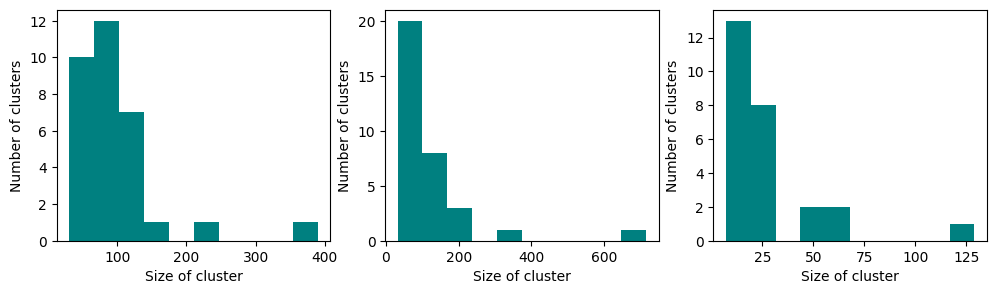

In [24]:
# Cluster sizes

fig, ax = plt.subplots(1, 3, figsize=(12,3))
ax[0].hist([len(cluster_to_response_autbrick[l]) for l in cluster_to_response_autbrick], color="teal")
ax[0].set_xlabel("Size of cluster")
ax[0].set_ylabel("Number of clusters")

ax[1].hist([len(cluster_to_response_autpaperclip[l]) for l in cluster_to_response_autpaperclip], color="teal")
ax[1].set_xlabel("Size of cluster")
ax[1].set_ylabel("Number of clusters")

ax[2].hist([len(cluster_to_response_vf[l]) for l in cluster_to_response_vf], color="teal")
ax[2].set_xlabel("Size of cluster")
ax[2].set_ylabel("Number of clusters")

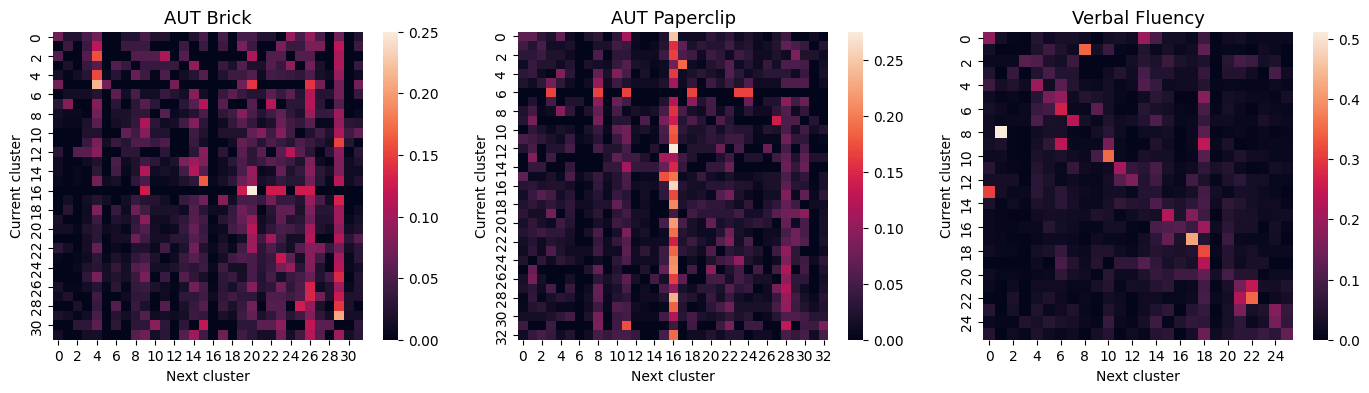

In [25]:
def get_cluster_transition_matrix(data, num_clusters):
    cluster_transition_matrix = np.zeros((num_clusters, num_clusters))
    for [cl1, cl2] in list(zip(data["previous_category"], data["category"])):
        try:
            cluster_transition_matrix[int(cl1) - 1, int(cl2) - 1] += 1
        except:
            continue
    
    row_sums = cluster_transition_matrix.sum(axis=1)[:, np.newaxis]
    # Avoid division by zero by adding a small number (epsilon) to row_sums
    epsilon = 1e-10
    return cluster_transition_matrix / (row_sums + epsilon)
    # return cluster_transition_matrix/cluster_transition_matrix.sum(axis = 1)

data_humans['previous_category'] = data_humans.groupby(['pid', 'task'])['category'].shift(1)
fig, ax = plt.subplots(1, 3, figsize=(17, 4))
sns.heatmap(get_cluster_transition_matrix(data_humans[data_humans["task"] == 2], 32), ax=ax[0])
ax[0].set_xlabel("Next cluster")
ax[0].set_ylabel("Current cluster")
ax[0].set_title("AUT Brick", fontsize=13)
sns.heatmap(get_cluster_transition_matrix(data_humans[data_humans["task"] == 3], 33), ax=ax[1])
ax[1].set_xlabel("Next cluster")
ax[1].set_ylabel("Current cluster")
ax[1].set_title("AUT Paperclip", fontsize=13)
sns.heatmap(get_cluster_transition_matrix(data_humans[data_humans["task"] == 1], 26), ax=ax[2])
ax[2].set_xlabel("Next cluster")
ax[2].set_ylabel("Current cluster")
ax[2].set_title("Verbal Fluency", fontsize=13);

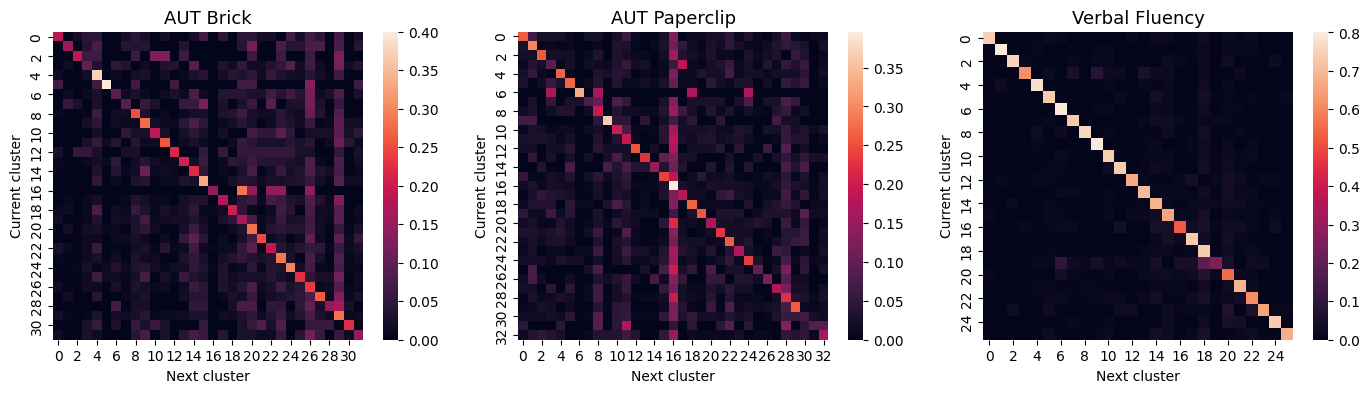

In [26]:
def get_cluster_transition_matrix(data, num_clusters):
    cluster_transition_matrix = np.zeros((num_clusters, num_clusters))
    for [cl1, cl2] in list(zip(data["previous_category_simaccounted"], data["category_simaccounted"])):
        try:
            cluster_transition_matrix[int(cl1) - 1, int(cl2) - 1] += 1
        except:
            continue
    
    row_sums = cluster_transition_matrix.sum(axis=1)[:, np.newaxis]
    # Avoid division by zero by adding a small number (epsilon) to row_sums
    epsilon = 1e-10
    return cluster_transition_matrix / (row_sums + epsilon)
    # return cluster_transition_matrix/cluster_transition_matrix.sum(axis = 1)

data_humans['previous_category_simaccounted'] = data_humans.groupby(['pid', 'task'])['category_simaccounted'].shift(1)
fig, ax = plt.subplots(1, 3, figsize=(17, 4))
sns.heatmap(get_cluster_transition_matrix(data_humans[data_humans["task"] == 2], 32), ax=ax[0])
ax[0].set_xlabel("Next cluster")
ax[0].set_ylabel("Current cluster")
ax[0].set_title("AUT Brick", fontsize=13)
sns.heatmap(get_cluster_transition_matrix(data_humans[data_humans["task"] == 3], 33), ax=ax[1])
ax[1].set_xlabel("Next cluster")
ax[1].set_ylabel("Current cluster")
ax[1].set_title("AUT Paperclip", fontsize=13)
sns.heatmap(get_cluster_transition_matrix(data_humans[data_humans["task"] == 1], 26), ax=ax[2])
ax[2].set_xlabel("Next cluster")
ax[2].set_ylabel("Current cluster")
ax[2].set_title("Verbal Fluency", fontsize=13);

Text(1113.2222222222222, 0.5, 'Current cluster')

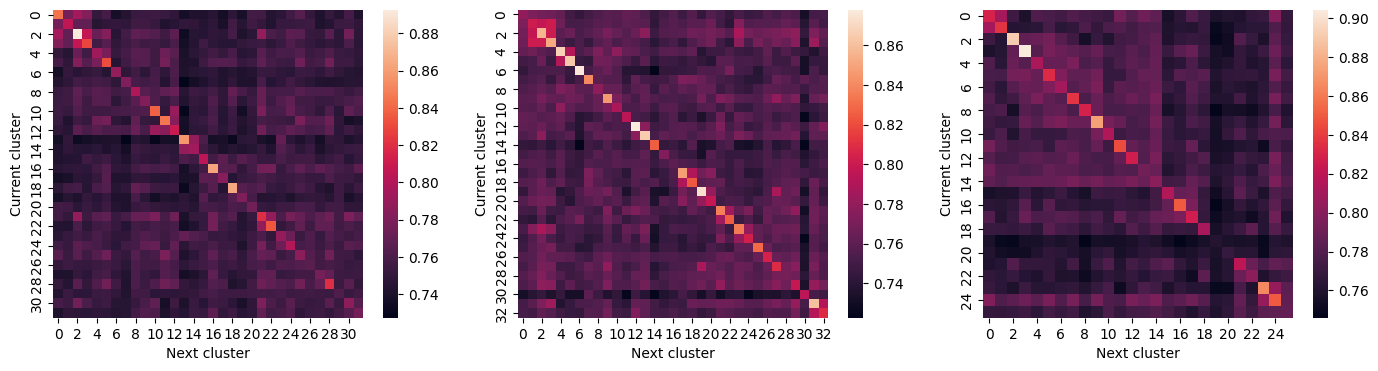

In [71]:
# Cluster similarity matrix:

# method 1 - median pairwise similarity between 2 clusters

cluster_sim_mat_autbrick = np.zeros((num_clusters_autbrick, num_clusters_autbrick))
for cl1 in cluster_to_response_autbrick:
    for cl2 in cluster_to_response_autbrick:
        r1_embeddings = np.array([sentence_transformer_embeddings_autbrick[r1] for r1 in cluster_to_response_autbrick[cl1]])
        r2_embeddings = np.array([sentence_transformer_embeddings_autbrick[r2] for r2 in cluster_to_response_autbrick[cl2]])
        similarity_matrix = np.dot(r1_embeddings, r2_embeddings.T)
        cluster_sim_mat_autbrick[cl1 - 1, cl2 - 1] = np.median(similarity_matrix)

cluster_sim_mat_autpaperclip = np.zeros((num_clusters_autpaperclip, num_clusters_autpaperclip))
for cl1 in cluster_to_response_autpaperclip:
    for cl2 in cluster_to_response_autpaperclip:
        r1_embeddings = np.array([sentence_transformer_embeddings_autpaperclip[r1] for r1 in cluster_to_response_autpaperclip[cl1]])
        r2_embeddings = np.array([sentence_transformer_embeddings_autpaperclip[r2] for r2 in cluster_to_response_autpaperclip[cl2]])
        similarity_matrix = np.dot(r1_embeddings, r2_embeddings.T)
        cluster_sim_mat_autpaperclip[cl1 - 1, cl2 - 1] = np.median(similarity_matrix)

cluster_sim_mat_vf = np.zeros((num_clusters_vf, num_clusters_vf))
for cl1 in cluster_to_response_vf:
    for cl2 in cluster_to_response_vf:
        r1_embeddings = np.array([sentence_transformer_embeddings_vf[r1] for r1 in cluster_to_response_vf[cl1]])
        r2_embeddings = np.array([sentence_transformer_embeddings_vf[r2] for r2 in cluster_to_response_vf[cl2]])
        similarity_matrix = np.dot(r1_embeddings, r2_embeddings.T)
        cluster_sim_mat_vf[cl1 - 1, cl2 - 1] = np.median(similarity_matrix)


fig, ax = plt.subplots(1, 3, figsize=(17, 4))
sns.heatmap(cluster_sim_mat_autbrick, annot=False, ax=ax[0])
ax[0].set_xlabel("Next cluster")
ax[0].set_ylabel("Current cluster")
sns.heatmap(cluster_sim_mat_autpaperclip, annot=False, ax=ax[1])
ax[1].set_xlabel("Next cluster")
ax[1].set_ylabel("Current cluster")
sns.heatmap(cluster_sim_mat_vf, annot=False, ax=ax[2]);
ax[2].set_xlabel("Next cluster")
ax[2].set_ylabel("Current cluster")

In [28]:
def scale_similarity_matrix(similarity_matrix, min_val=0, max_val=10):
    # Normalize the matrix to a 0-1 range
    min_sim = np.min(similarity_matrix)
    max_sim = np.max(similarity_matrix)
    scaled_matrix = (similarity_matrix - min_sim) / (max_sim - min_sim)
    
    # Scale the matrix to the specified range (0 to 10)
    scaled_matrix = scaled_matrix * (max_val - min_val) + min_val
    return scaled_matrix

scaled_cluster_sim_mat_autbrick = scale_similarity_matrix(cluster_sim_mat_autbrick)
scaled_cluster_sim_mat_autpaperclip = scale_similarity_matrix(cluster_sim_mat_autpaperclip)
scaled_cluster_sim_mat_vf = scale_similarity_matrix(cluster_sim_mat_vf)

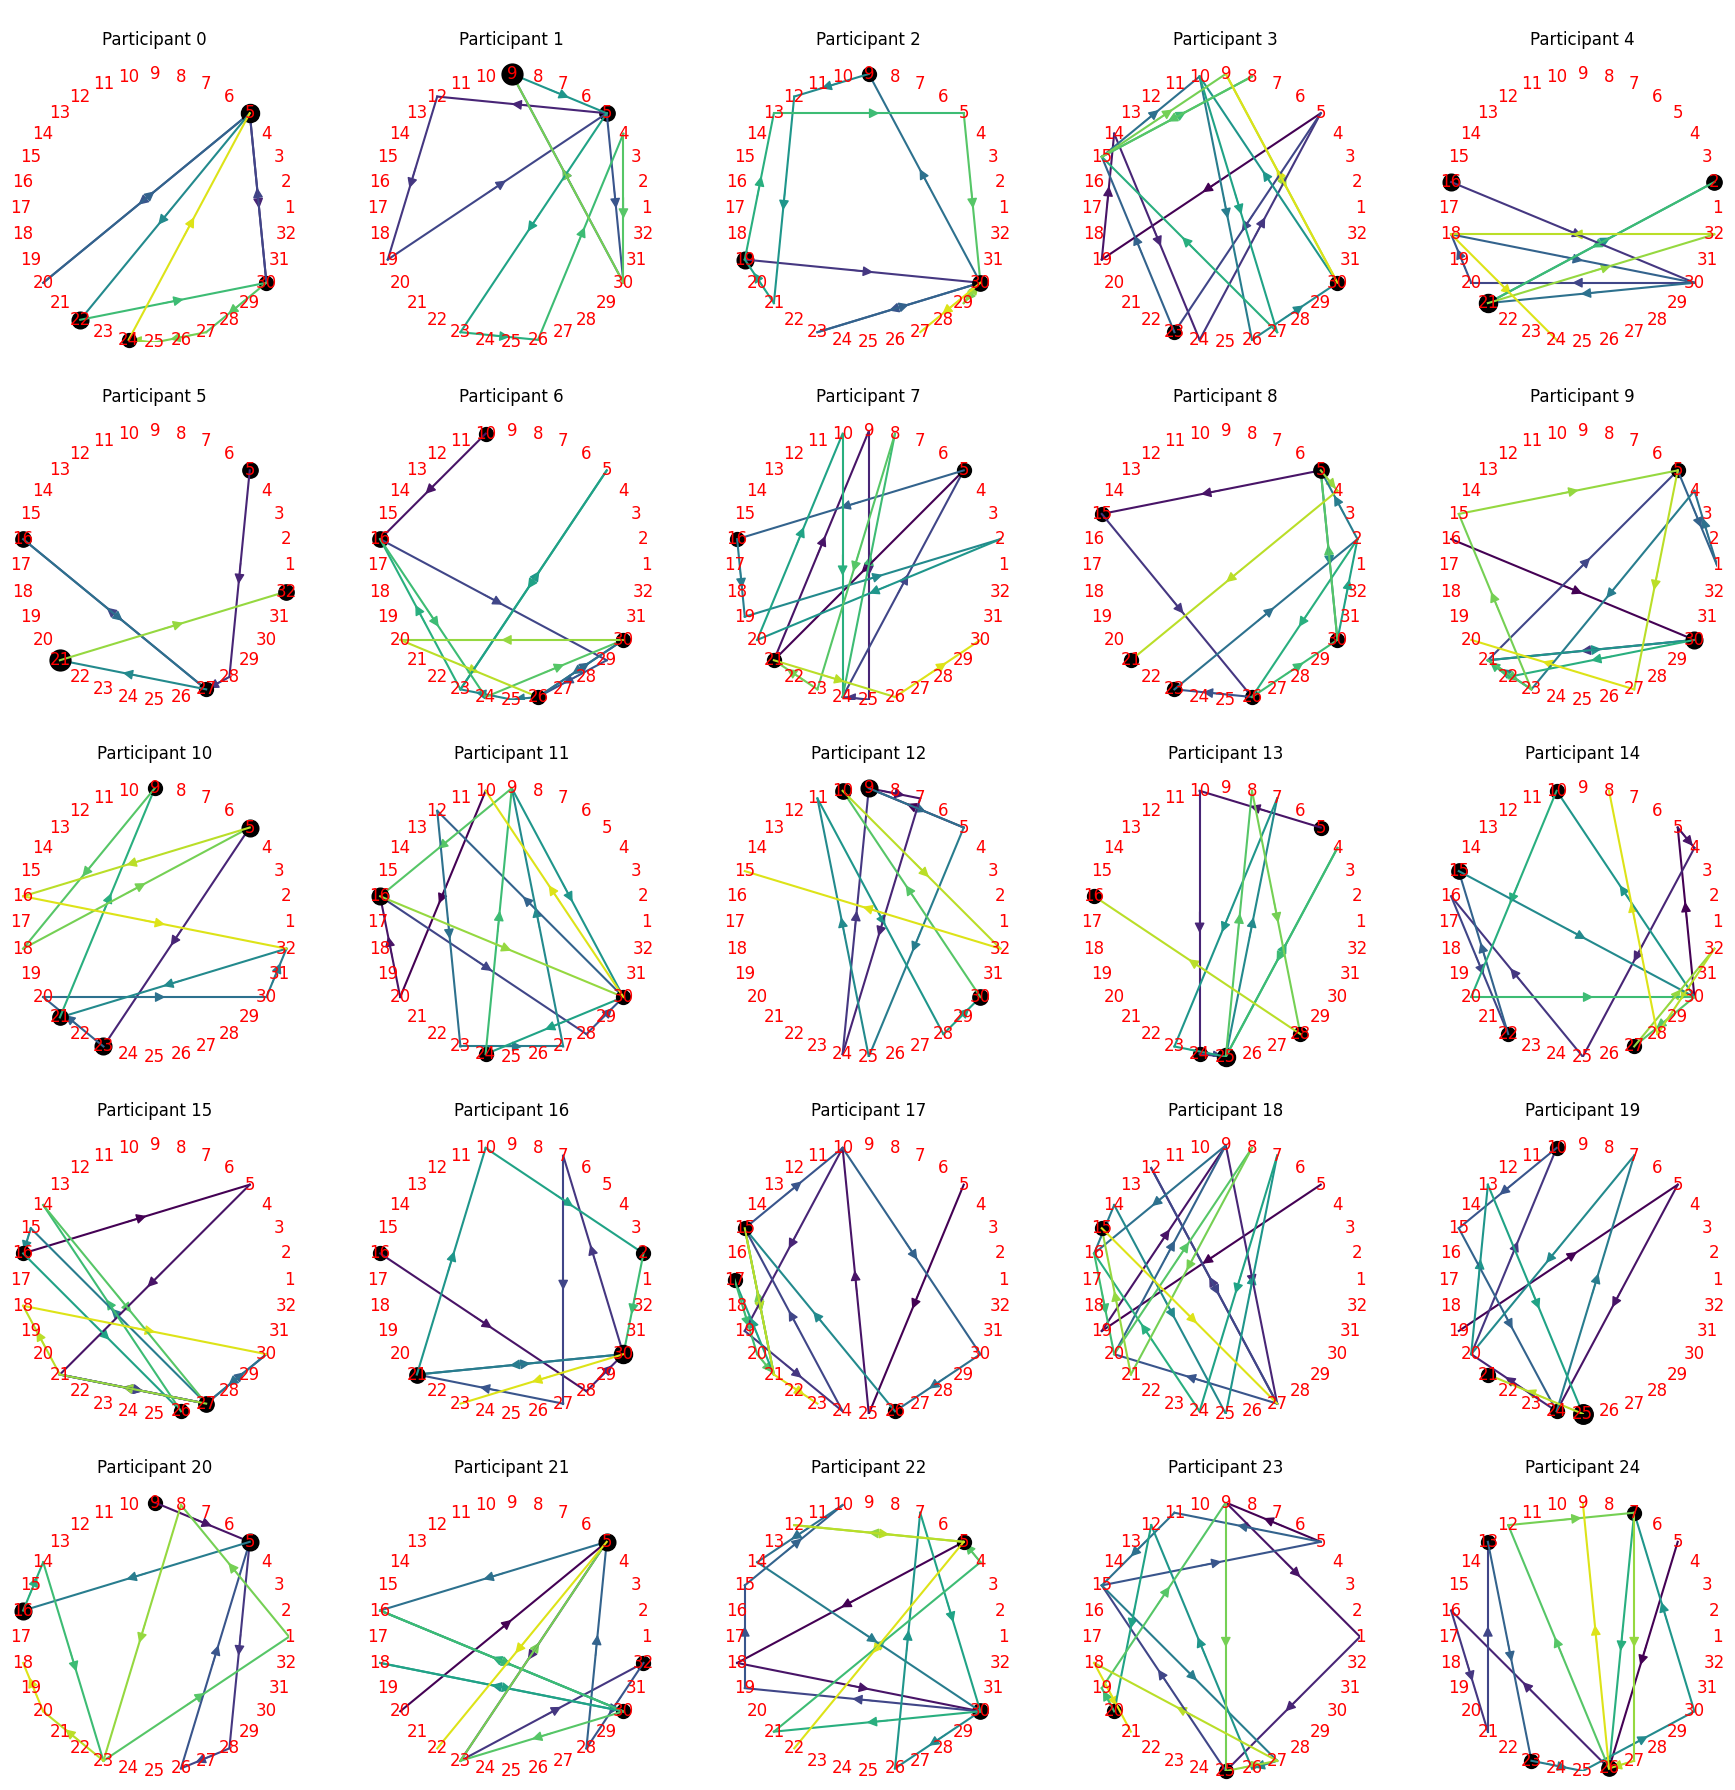

In [29]:
marker_sizes = {}
fig, ax = plt.subplots(5, 5, figsize=(18,18))
i = 0
for pid in data_humans[data_humans["task"] == 2]["pid"].unique():
    marker_sizes = {}
    categ_list = data_humans[(data_humans["task"] == 2) & (data_humans["pid"] == pid)]["category_simaccounted"].tolist()
    if len(categ_list) < 20:
        continue
    try:
        plot_movement(categ_list[:20], i, ax[i//5, i%5], max(data_humans[data_humans["task"] == 2]["category_simaccounted"].values), marker_sizes)
        i = i + 1
    except:
        continue
plt.tight_layout()
plt.show()

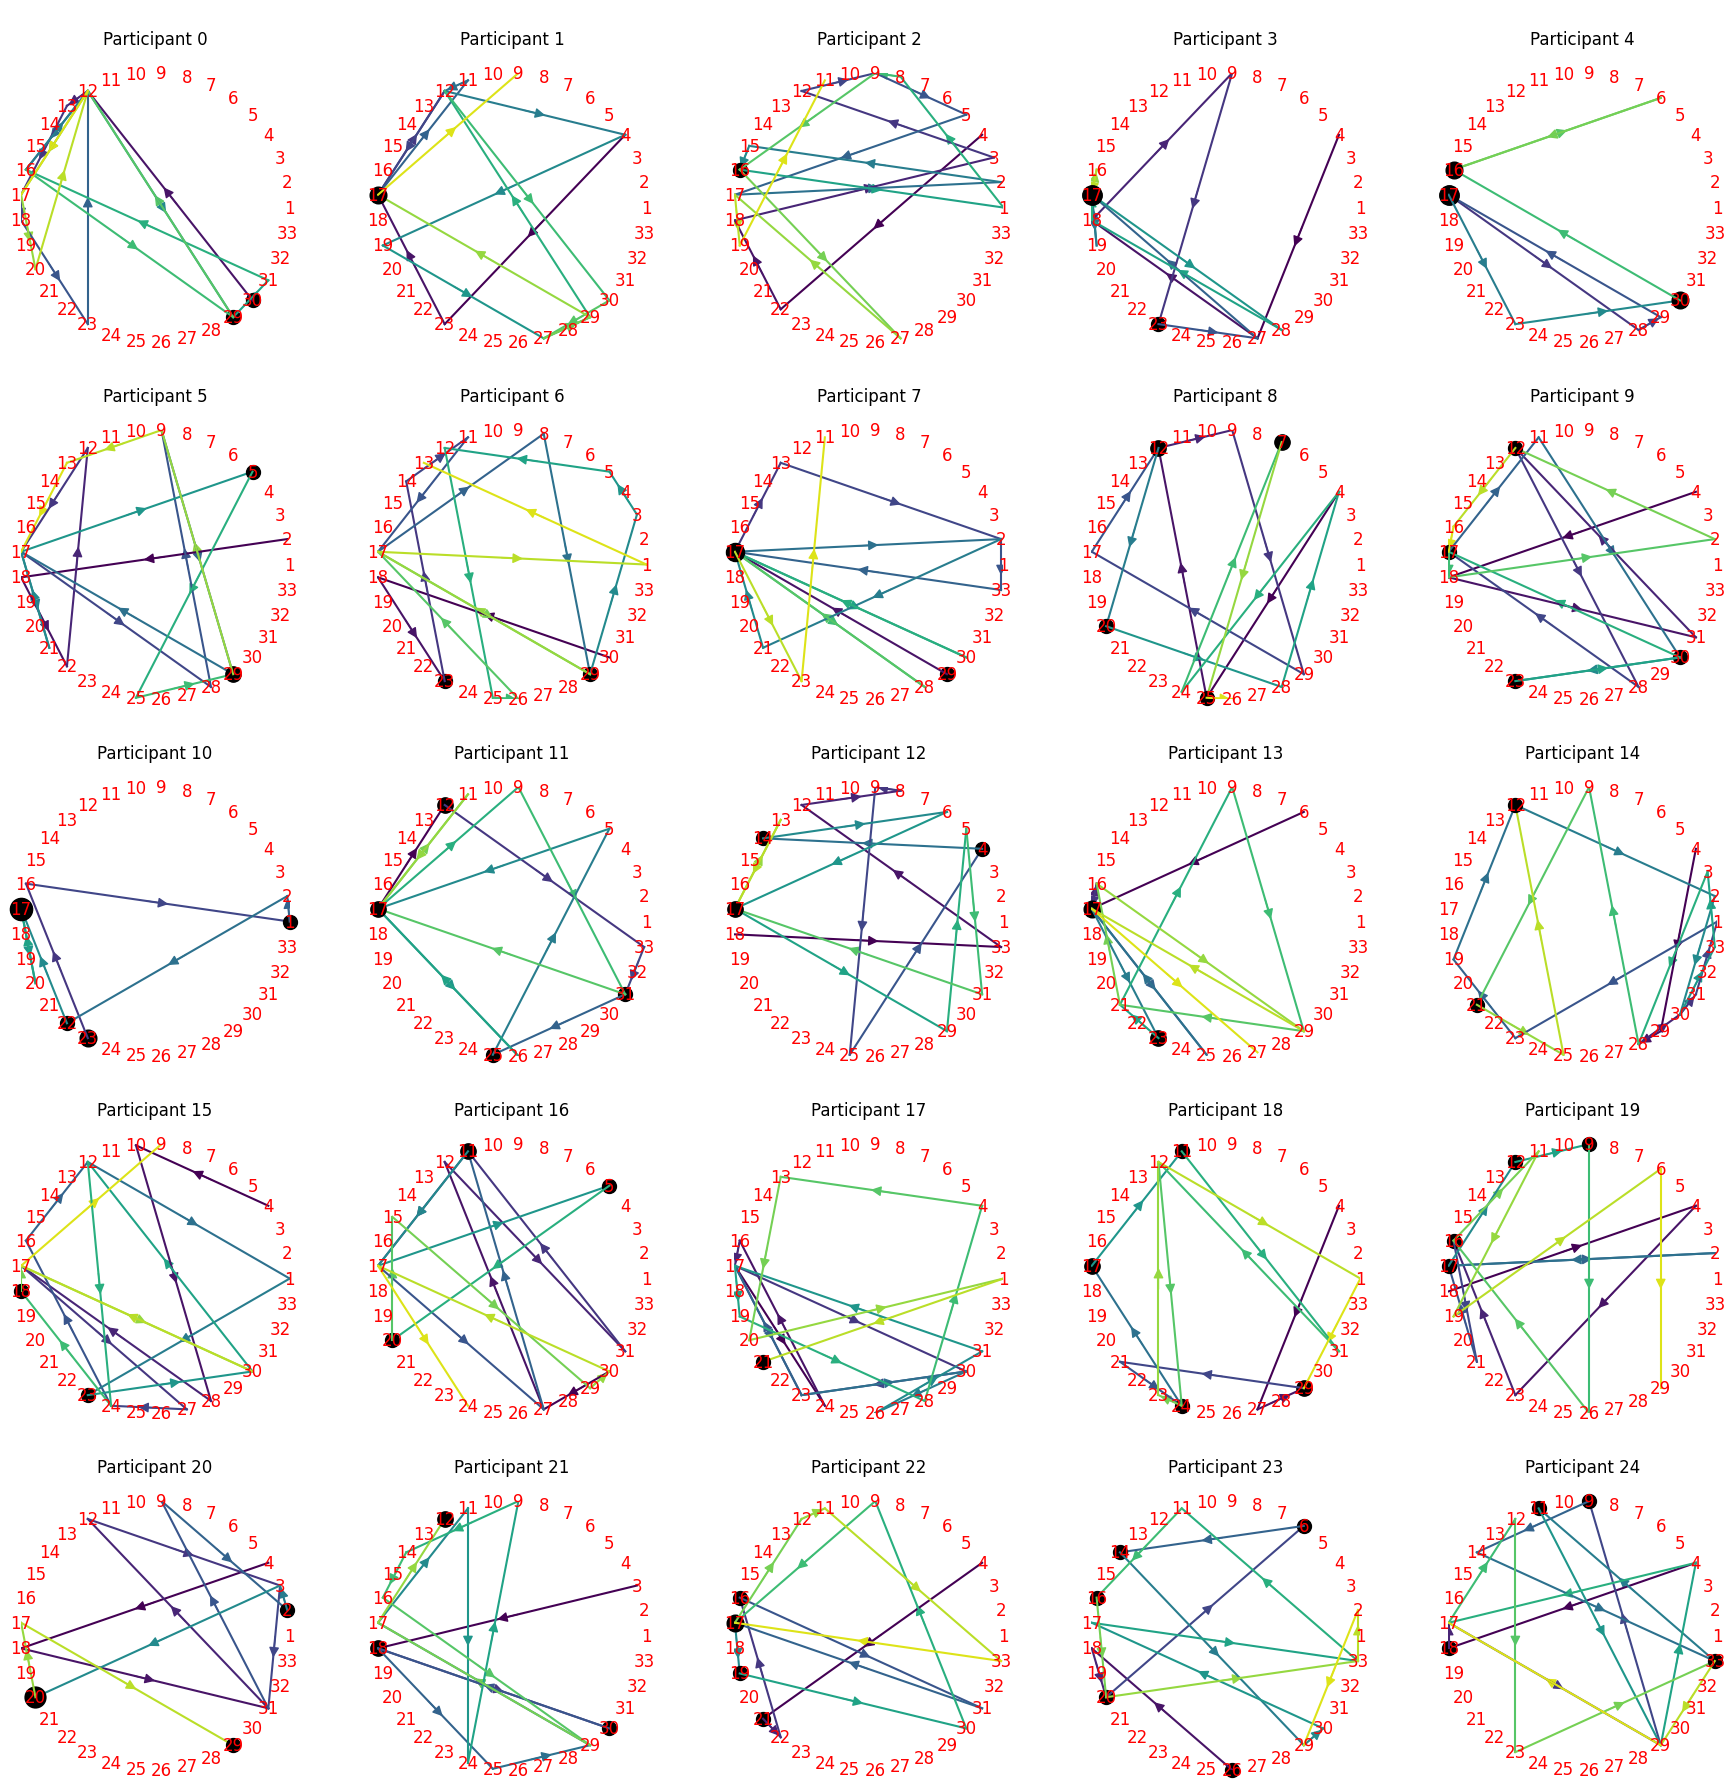

In [30]:
marker_sizes = {}
fig, ax = plt.subplots(5, 5, figsize=(18,18))
i = 0
for pid in data_humans[data_humans["task"] == 3]["pid"].unique():
    marker_sizes = {}
    categ_list = data_humans[(data_humans["task"] == 3) & (data_humans["pid"] == pid)]["category_simaccounted"].tolist()
    if len(categ_list) < 20:
        continue
    try:
        plot_movement(categ_list[:20], i, ax[i//5, i%5], max(data_humans[data_humans["task"] == 3]["category_simaccounted"].values), marker_sizes)
        i = i + 1
    except:
        continue
plt.tight_layout()
plt.show()

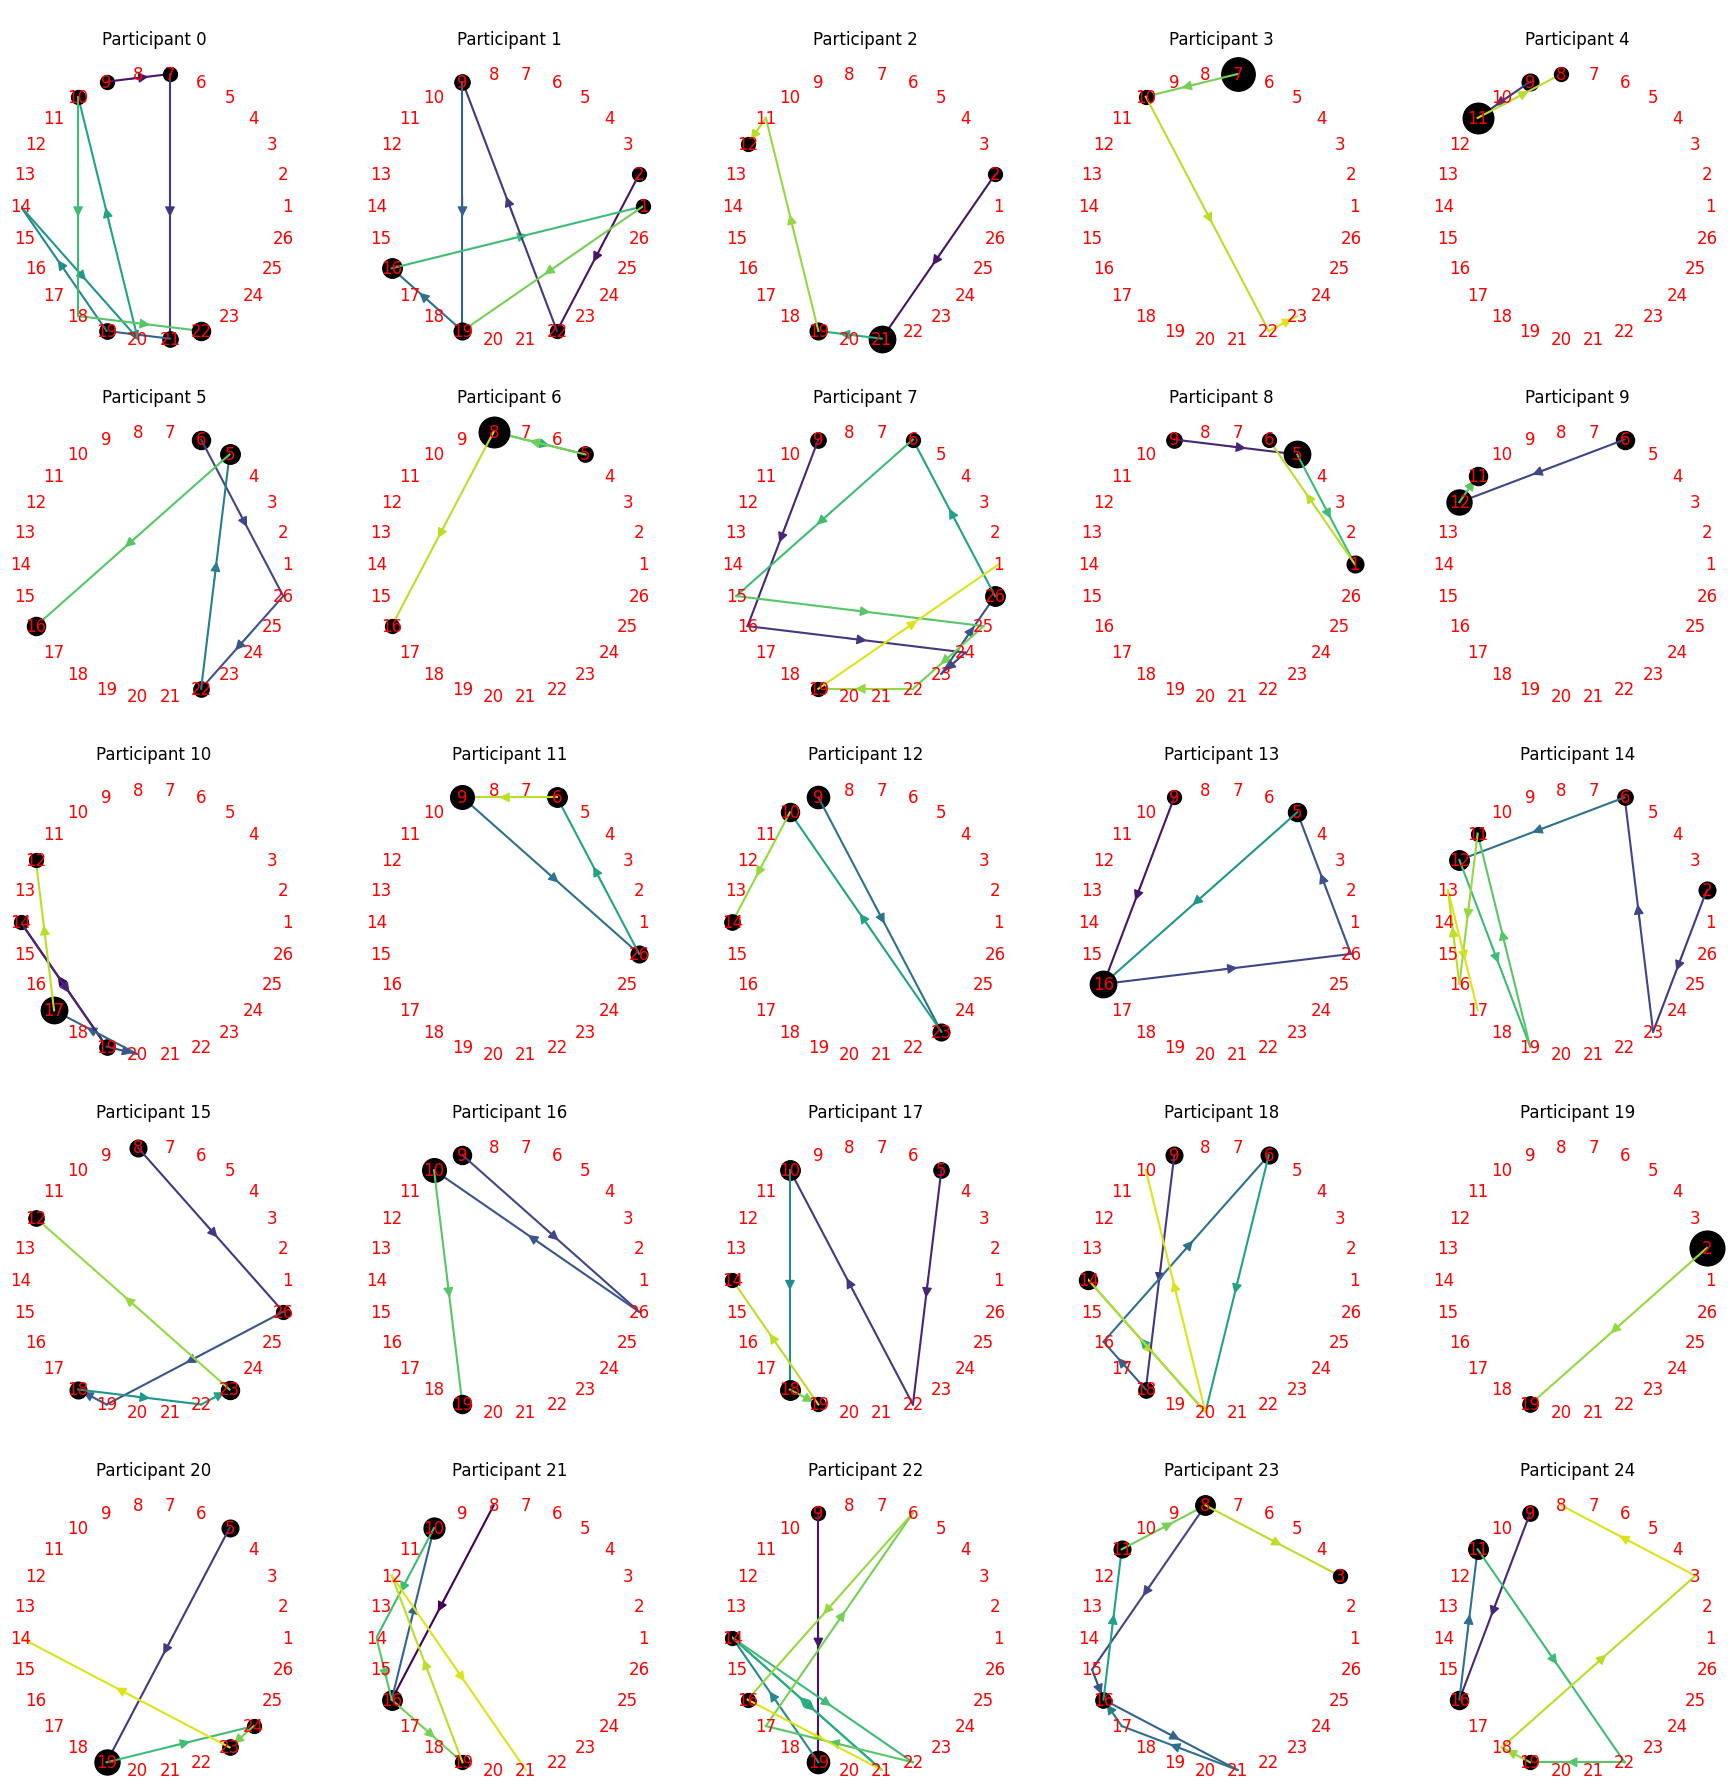

In [31]:
fig, ax = plt.subplots(5, 5, figsize=(18,18))
i = 0
for pid in data_humans[data_humans["task"] == 1]["pid"].unique():
    marker_sizes = {}
    categ_list = data_humans[(data_humans["task"] == 1) & (data_humans["pid"] == pid)]["category_simaccounted"].tolist()
    if len(categ_list) < 20:
        continue
    try:
        plot_movement(categ_list[:20], i, ax[i//5, i%5], max(data_humans[data_humans["task"] == 1]["category_simaccounted"].values), marker_sizes)
        i = i + 1
    except:
        continue
plt.tight_layout()
plt.show()

# When people jump back, how far back do they jump?

In [32]:
seq_len = 20

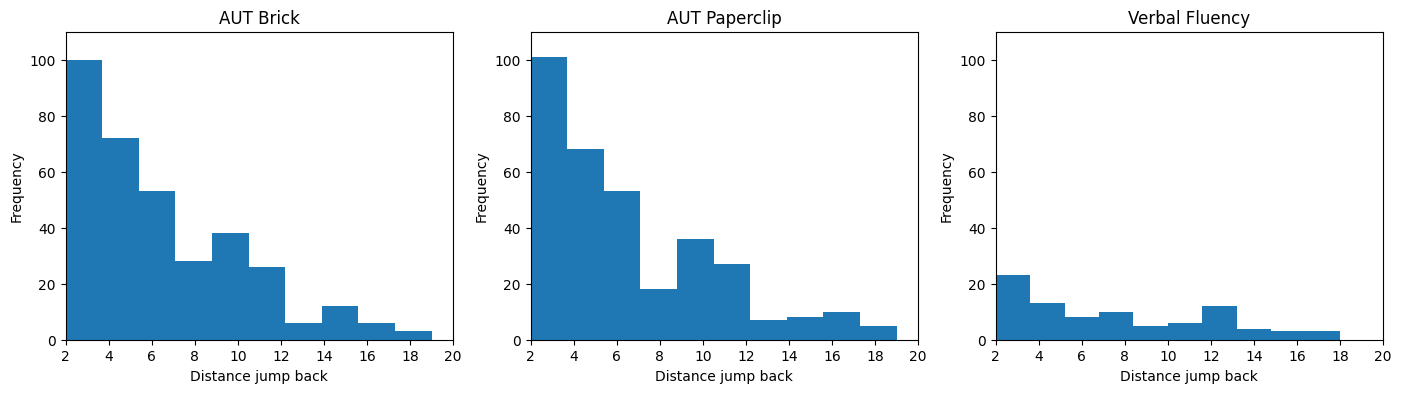

In [75]:
def find_repeated_cluster_distances_from_end(cluster_sequence):
    last_pos = {}
    distances = []
    
    # Iterate through the sequence starting from the end
    for i in reversed(range(len(cluster_sequence))):
        cluster = cluster_sequence[i]
        
        if cluster in last_pos and last_pos[cluster] != i + 1:
            # Calculate distance if the cluster is not repeated directly
            distance = last_pos[cluster] - i
            distances.append((cluster, distance, i, last_pos[cluster]))
        
        # Update the last seen position of the cluster
        last_pos[cluster] = i
    
    return distances

rep_lengths_autbrick = []
for pid in data_humans[data_humans["task"] == 2]["pid"].unique(): 
    categ_list = data_humans[(data_humans["task"] == 2) & (data_humans["pid"] == pid)]["category_simaccounted"].tolist()
    if len(categ_list) < seq_len:
        continue
    categ_list = categ_list[:seq_len]
    # print(categ_list)
    distances = find_repeated_cluster_distances_from_end(categ_list)
    # print(pid, list(reversed(distances)))
    for item in list(reversed(distances)):
        rep_lengths_autbrick.append(item[1])

rep_lengths_autpaperclip = []
for pid in data_humans[data_humans["task"] == 3]["pid"].unique(): 
    categ_list = data_humans[(data_humans["task"] == 3) & (data_humans["pid"] == pid)]["category_simaccounted"].tolist()
    if len(categ_list) < seq_len:
        continue
    categ_list = categ_list[:seq_len]
    # print(categ_list)
    distances = find_repeated_cluster_distances_from_end(categ_list)
    # print(pid, list(reversed(distances)))
    for item in list(reversed(distances)):
        rep_lengths_autpaperclip.append(item[1])

rep_lengths_vf = []
for pid in data_humans[data_humans["task"] == 1]["pid"].unique(): 
    categ_list = data_humans[(data_humans["task"] == 1) & (data_humans["pid"] == pid)]["category_simaccounted"].tolist()
    if len(categ_list) < seq_len:
        continue
    categ_list = categ_list[:seq_len]
    # print(categ_list)
    distances = find_repeated_cluster_distances_from_end(categ_list)
    # print(pid, list(reversed(distances)))
    for item in list(reversed(distances)):
        rep_lengths_vf.append(item[1])

fig, ax = plt.subplots(1, 3, figsize=(17, 4))
ax[0].hist(rep_lengths_autbrick)
ax[0].set_title("AUT Brick")
ax[0].set_xlabel("Distance jump back")
ax[0].set_ylabel("Frequency")
ax[0].set_xlim(2, seq_len)
ax[0].set_ylim(0, 110)

ax[1].hist(rep_lengths_autpaperclip)
ax[1].set_title("AUT Paperclip")
ax[1].set_xlim(2, seq_len)
ax[1].set_ylim(0, 110)
ax[1].set_xlabel("Distance jump back")
ax[1].set_ylabel("Frequency")

ax[2].hist(rep_lengths_vf)
ax[2].set_title("Verbal Fluency")
ax[2].set_ylim(0, 110)
ax[2].set_xlabel("Distance jump back")
ax[2].set_ylabel("Frequency")
ax[2].set_xlim(2, seq_len);

# When people jump ahead, how much do they exploit it?

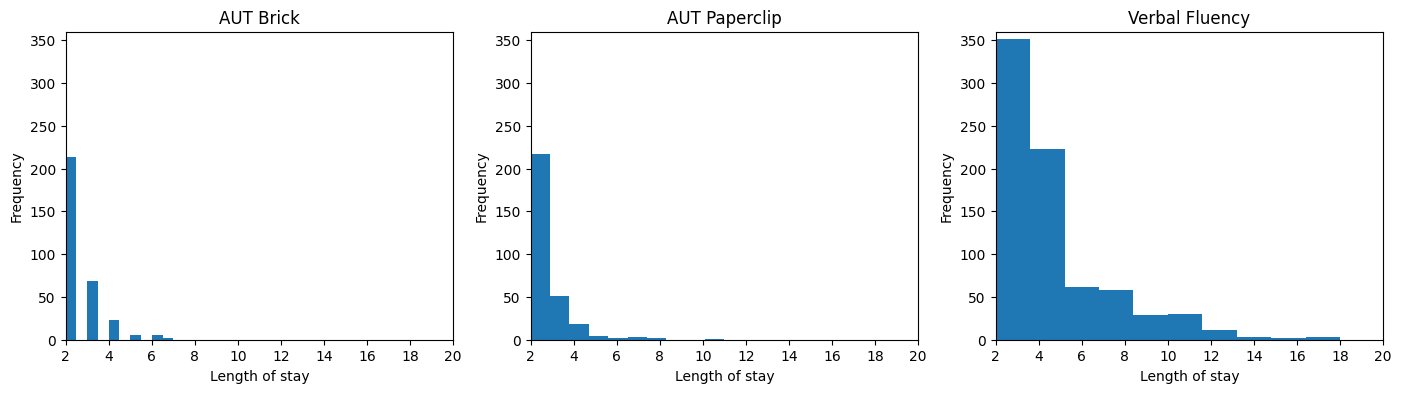

In [76]:
def find_stay_durations(cluster_sequence):
    durations = []
    n = len(cluster_sequence)
    start = 0
    while start < n:
        current_cluster = cluster_sequence[start]
        end = start
        
        while end < n and cluster_sequence[end] == current_cluster:
            end += 1
        
        duration = end - start
        if duration > 1:
            durations.append((current_cluster, duration, start, end - 1))
        start = end    
    return durations

# Example cluster sequence
stay_lengths_autbrick = []
for pid in data_humans[data_humans["task"] == 2]["pid"].unique(): 
    categ_list = data_humans[(data_humans["task"] == 2) & (data_humans["pid"] == pid)]["category_simaccounted"].tolist()
    if len(categ_list) < seq_len:
        continue
    categ_list = categ_list[:seq_len]
    stay_durations = find_stay_durations(categ_list)
    # print(stay_durations)
    for item in list(reversed(stay_durations)):
        stay_lengths_autbrick.append(item[1])

stay_lengths_autpaperclip = []
for pid in data_humans[data_humans["task"] == 3]["pid"].unique(): 
    categ_list = data_humans[(data_humans["task"] == 3) & (data_humans["pid"] == pid)]["category_simaccounted"].tolist()
    if len(categ_list) < seq_len:
        continue
    categ_list = categ_list[:seq_len]
    stay_durations = find_stay_durations(categ_list)
    # print(stay_durations)
    for item in list(reversed(stay_durations)):
        stay_lengths_autpaperclip.append(item[1])
    
stay_lengths_vf = []
for pid in data_humans[data_humans["task"] == 1]["pid"].unique(): 
    categ_list = data_humans[(data_humans["task"] == 1) & (data_humans["pid"] == pid)]["category_simaccounted"].tolist()
    if len(categ_list) < seq_len:
        continue
    categ_list = categ_list[:seq_len]
    stay_durations = find_stay_durations(categ_list)
    # print(stay_durations)
    for item in list(reversed(stay_durations)):
        stay_lengths_vf.append(item[1])

fig, ax = plt.subplots(1, 3, figsize=(17, 4))
ax[0].hist(stay_lengths_autbrick)
ax[0].set_title("AUT Brick")
ax[0].set_xlim(2, seq_len)
ax[0].set_xlabel("Length of stay")
ax[0].set_ylabel("Frequency")
ax[0].set_ylim(0, 360)
ax[1].hist(stay_lengths_autpaperclip)
ax[1].set_title("AUT Paperclip")
ax[1].set_xlim(2, seq_len)
ax[1].set_xlabel("Length of stay")
ax[1].set_ylabel("Frequency")
ax[1].set_ylim(0, 360)
ax[2].hist(stay_lengths_vf)
ax[2].set_title("Verbal Fluency")
ax[2].set_ylim(0, 360)
ax[2].set_xlabel("Length of stay")
ax[2].set_ylabel("Frequency")
ax[2].set_xlim(2, seq_len);

In [ ]:
# jump vs stays

data_humans[(data_humans["task"] == 2) & (data_humans["order"] > 0)][["jump", "RT", "RT_think", "RT_think_transformed", "SS"]].groupby("jump").mean()

# All significant
# t_stat, p_val = stats.ttest_ind(data_humans[(data_humans["task"] == 2) & (data_humans["order"] > 0) & ((data_humans["jump"] == 0))]["RT"], data_humans[(data_humans["task"] == 2) & (data_humans["order"] > 0) & ((data_humans["jump"] == 1))]["RT"])
# print(p_val)
# t_stat, p_val = stats.ttest_ind(data_humans[(data_humans["task"] == 2) & (data_humans["order"] > 0) & ((data_humans["jump"] == 0))]["RT_think"], data_humans[(data_humans["task"] == 2) & (data_humans["order"] > 0) & ((data_humans["jump"] == 1))]["RT_think"])
# print(p_val)
# t_stat, p_val = stats.ttest_ind(data_humans[(data_humans["task"] == 2) & (data_humans["order"] > 0) & ((data_humans["jump"] == 0))]["SS"], data_humans[(data_humans["task"] == 2) & (data_humans["order"] > 0) & ((data_humans["jump"] == 1))]["SS"])
# print(p_val)

# Project this as random walk based on similarities

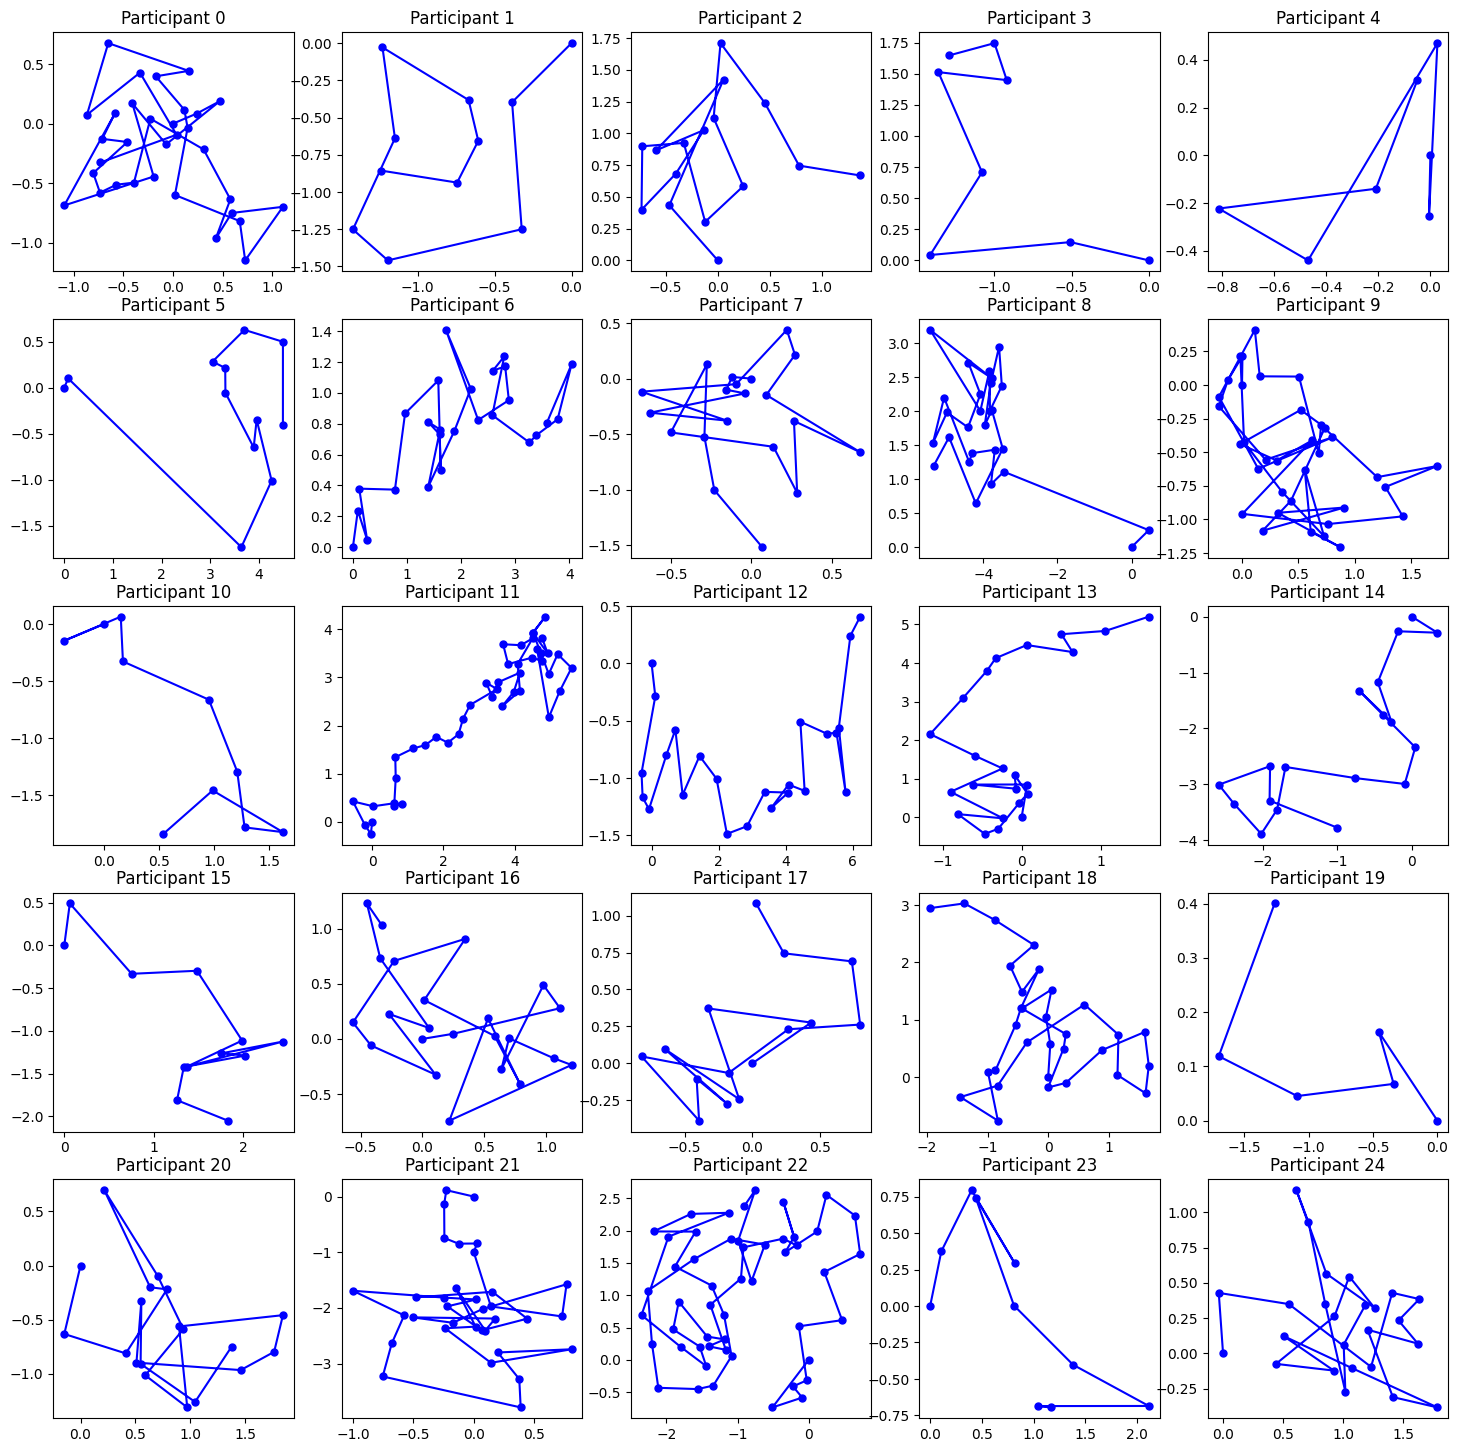

In [42]:
fig, ax = plt.subplots(5, 5, figsize=(18,18))

def random_walk(cluster_visits, cluster_sim_mat):
    positions = [(0, 0)]  # Start at the origin
    current_position = np.array([0, 0])  # Start position
    
    for i in range(1, len(cluster_visits)):
        current_cluster = cluster_visits[i-1]
        next_cluster = cluster_visits[i]
        
        # Get similarity from the matrix
        similarity = cluster_sim_mat[current_cluster - 1, next_cluster - 1]
        if similarity == 0:  # Handle edge case where similarity might be zero
            step_size = np.inf  # Handle division by zero
        else:
            step_size = 1 / similarity  # Larger similarity = smaller step size

        # while True: 
        random_angle = np.random.uniform(0, 2 * np.pi)
        step_vector = np.array([np.cos(random_angle), np.sin(random_angle)]) * step_size
        current_position = current_position + step_vector
            # if (current_position[0] > 0 and current_position[0] < boundary) and (current_position[1] > 0 and current_position[1] < boundary):
            #     break

        positions.append(tuple(current_position))
    
    return positions

# Generate the random walk
i = 0
for pid in data_humans[data_humans["task"] == 2]["pid"].unique():
    marker_sizes = {}
    categ_list = data_humans[(data_humans["task"] == 2) & (data_humans["pid"] == pid)]["category_simaccounted"].tolist()
    path = random_walk(categ_list, scaled_cluster_sim_mat_autbrick)

    # Extract x and y coordinates from the positions
    x_coords, y_coords = zip(*path)

    # Plot the random walk
    try:
        ax[i//5, i%5].plot(x_coords, y_coords, marker='o', linestyle='-', markersize=5, color='blue')
        ax[i//5, i%5].set_title(f"Participant {i}")
        # ax[i//5, i%5].set_xlim(-5, 5)
        # ax[i//5, i%5].set_ylim(-5, 5)
        i += 1
    except:
        break

plt.show()

# Raw Responses

KeyError: 'SS_ref'

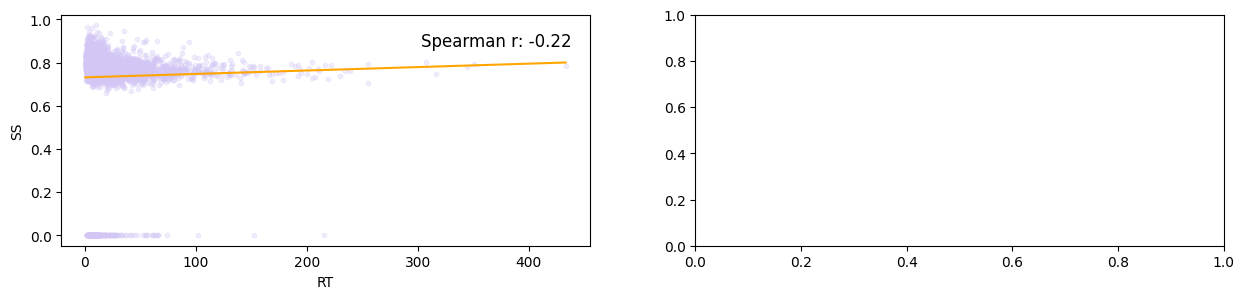

In [43]:
fig, ax = plt.subplots(1,2, figsize=(15, 3))

ax[0].scatter(data_humans[data_humans["task"] == 2]["RT"], data_humans[data_humans["task"] == 2]["SS"], s=10, alpha=0.3, c="#d3c6f5")
slope, intercept, r_value, p_value, std_err = stats.linregress(data_humans[data_humans["task"] == 2]["RT"], data_humans[data_humans["task"] == 2]["SS"])
line_x = np.linspace(data_humans[data_humans["task"] == 2]["RT"].min(), data_humans[data_humans["task"] == 2]["RT"].max(), 100)
line_y = slope * line_x + intercept

# Plot the regression line
ax[0].plot(line_x, line_y, color='orange', label=f'Fit Line: y={slope:.2f}x+{intercept:.2f}')

# Add Pearson correlation coefficient to the plot
spearman_corr, _ = stats.spearmanr(data_humans[data_humans["task"] == 2]["RT"], data_humans[data_humans["task"] == 2]["SS"])
ax[0].text(np.max(data_humans[data_humans["task"] == 2]["RT"])*0.7, np.max(data_humans[data_humans["task"] == 2]["SS"])*0.9, f'Spearman r: {spearman_corr:.2f}', fontsize=12)
ax[0].set_xlabel("RT")
ax[0].set_ylabel("SS");


ax[1].scatter(data_humans[data_humans["task"] == 2]["RT"], data_humans[data_humans["task"] == 2]["SS_ref"], s=10, alpha=0.3, c="#d3c6f5")
slope, intercept, r_value, p_value, std_err = stats.linregress(data_humans[data_humans["task"] == 2]["RT"], data_humans[data_humans["task"] == 2]["SS_ref"])
line_x = np.linspace(data_humans[data_humans["task"] == 2]["RT"].min(), data_humans[data_humans["task"] == 2]["RT"].max(), 100)
line_y = slope * line_x + intercept

# Plot the regression line
ax[1].plot(line_x, line_y, color='orange', label=f'Fit Line: y={slope:.2f}x+{intercept:.2f}')

# Add Pearson correlation coefficient to the plot
spearman_corr, _ = stats.spearmanr(data_humans[data_humans["task"] == 2]["RT"], data_humans[data_humans["task"] == 2]["SS_ref"])
ax[1].text(np.max(data_humans[data_humans["task"] == 2]["RT"])*0.7, np.max(data_humans[data_humans["task"] == 2]["SS_ref"])*0.9, f'Spearman r: {spearman_corr:.2f}', fontsize=12)
ax[1].set_xlabel("RT")
ax[1].set_ylabel("SS_ref");

In [44]:
numeric_cols = data_humans.select_dtypes(include=[np.number]).columns

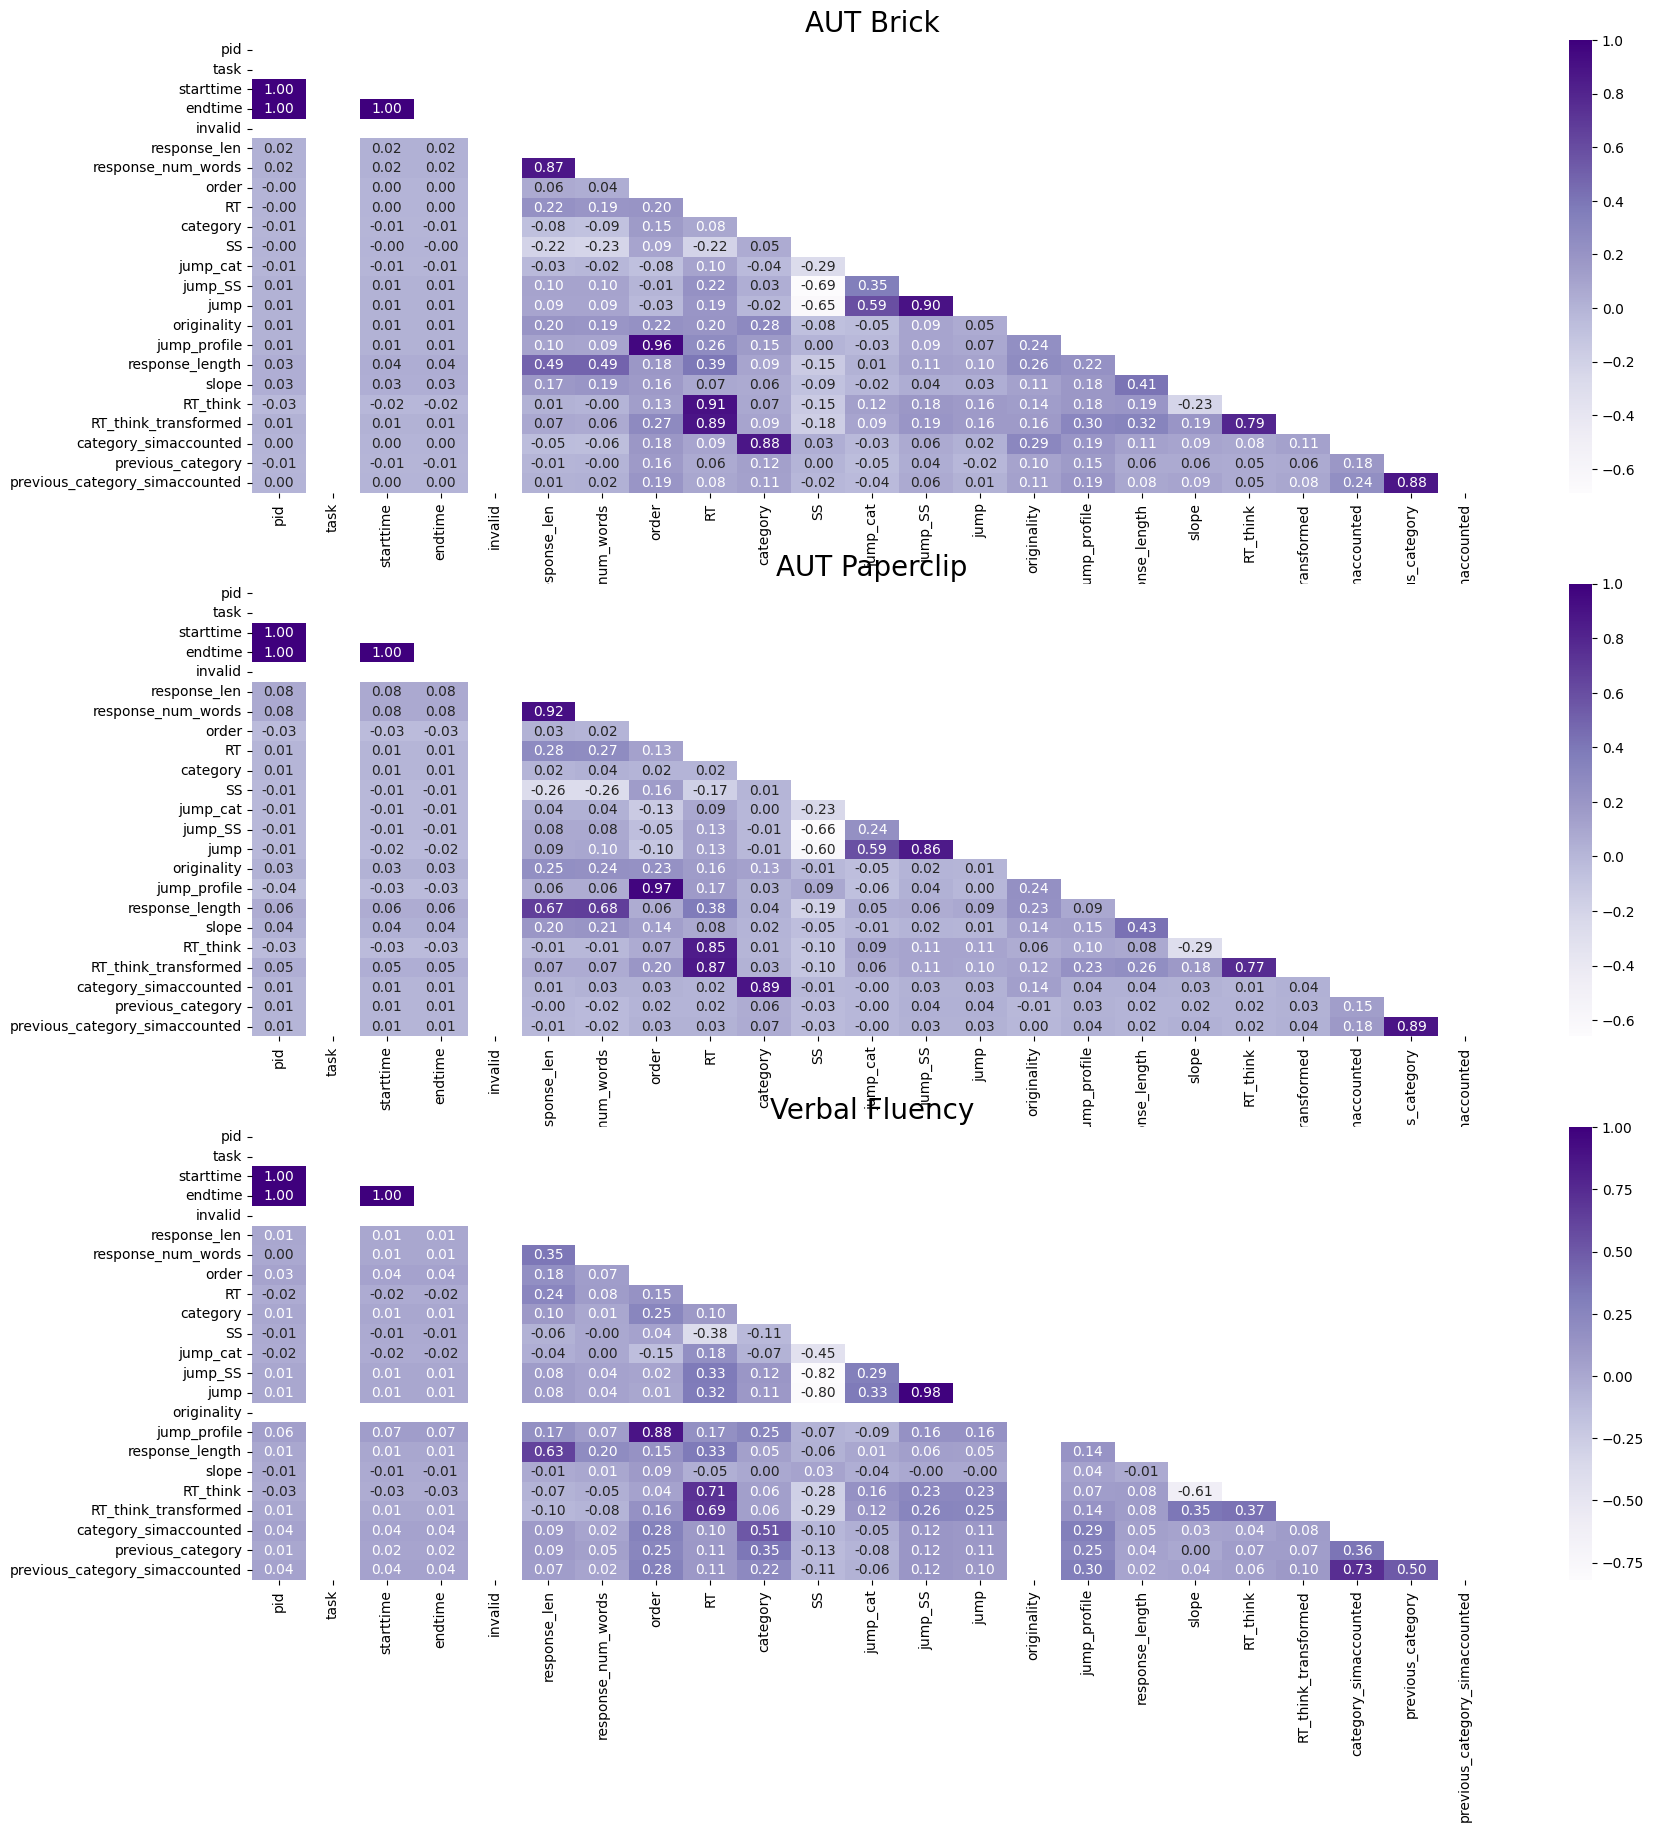

In [45]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
corr = data_humans[data_humans["task"] == 2][numeric_cols].corr(method='spearman').round(decimals=2)
matrix = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Purples", mask=matrix, ax = ax[0])
ax[0].set_title('AUT Brick', fontsize=20)

corr = data_humans[data_humans["task"] == 3][numeric_cols].corr(method='spearman').round(decimals=2)
matrix = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Purples", mask=matrix, ax = ax[1])
ax[1].set_title('AUT Paperclip', fontsize=20)

corr = data_humans[data_humans["task"] == 1][numeric_cols].corr(method='spearman').round(decimals=2)
matrix = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Purples", mask=matrix, ax = ax[2])
ax[2].set_title('Verbal Fluency', fontsize=20);

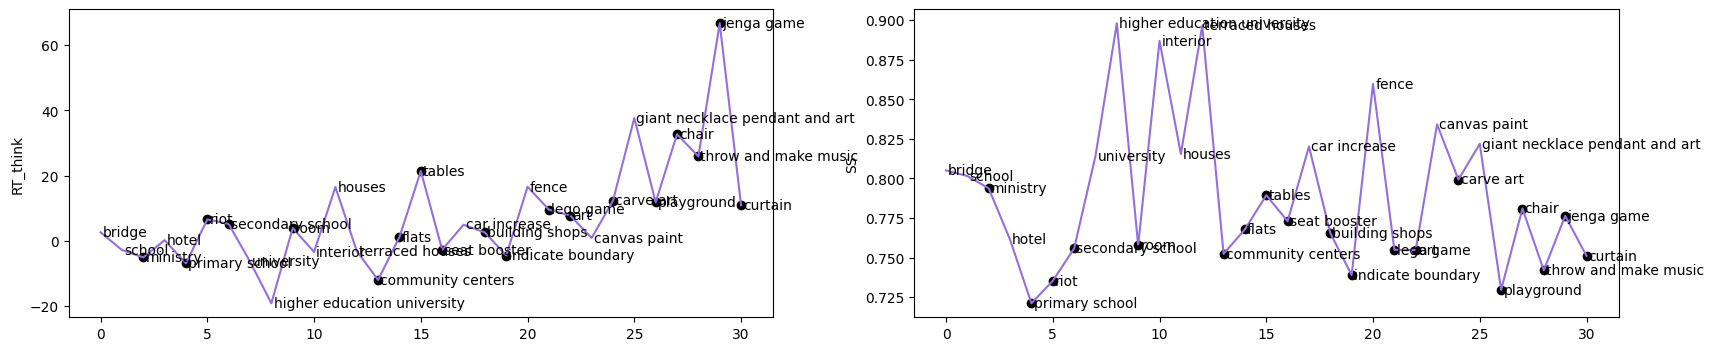

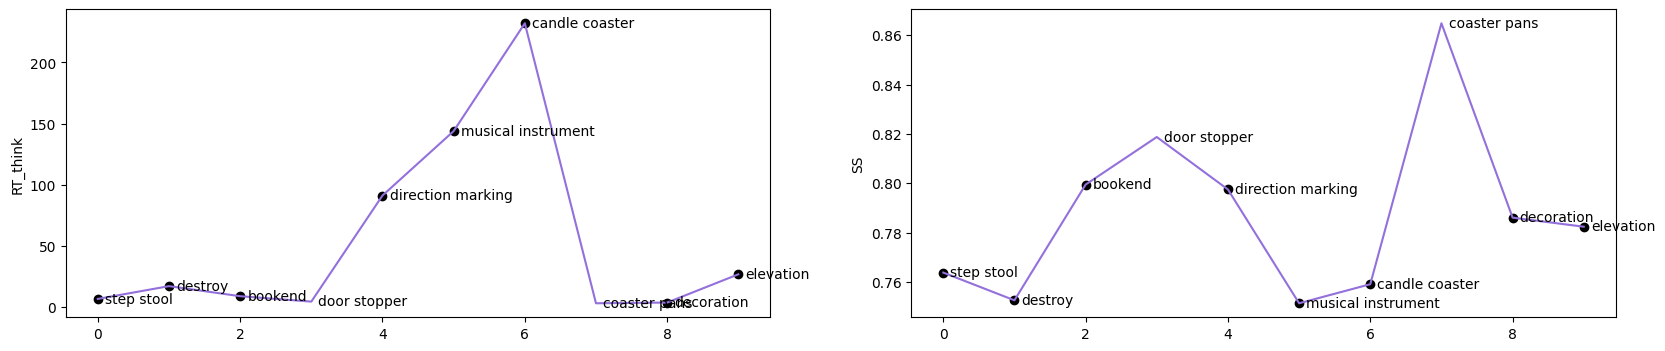

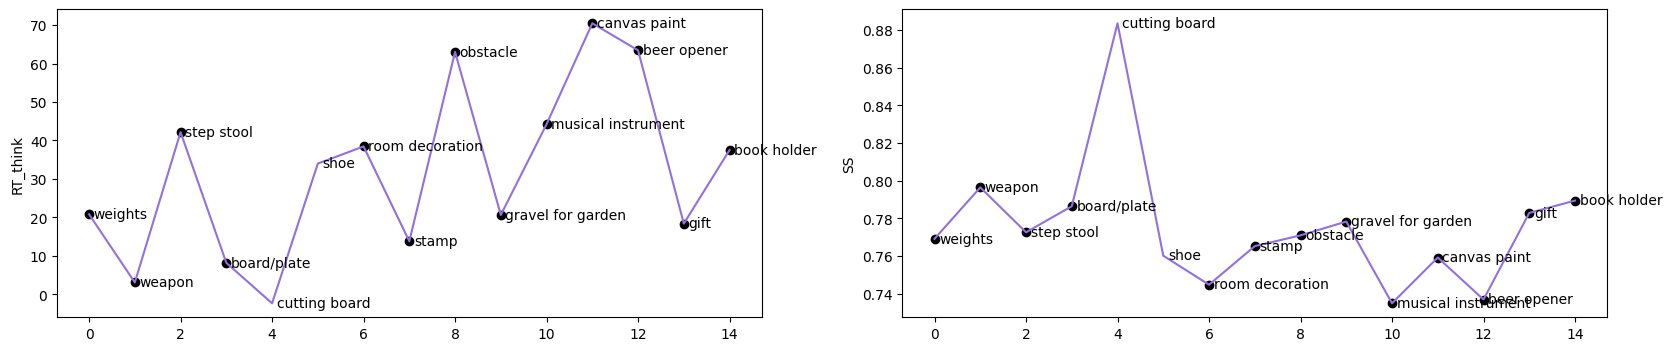

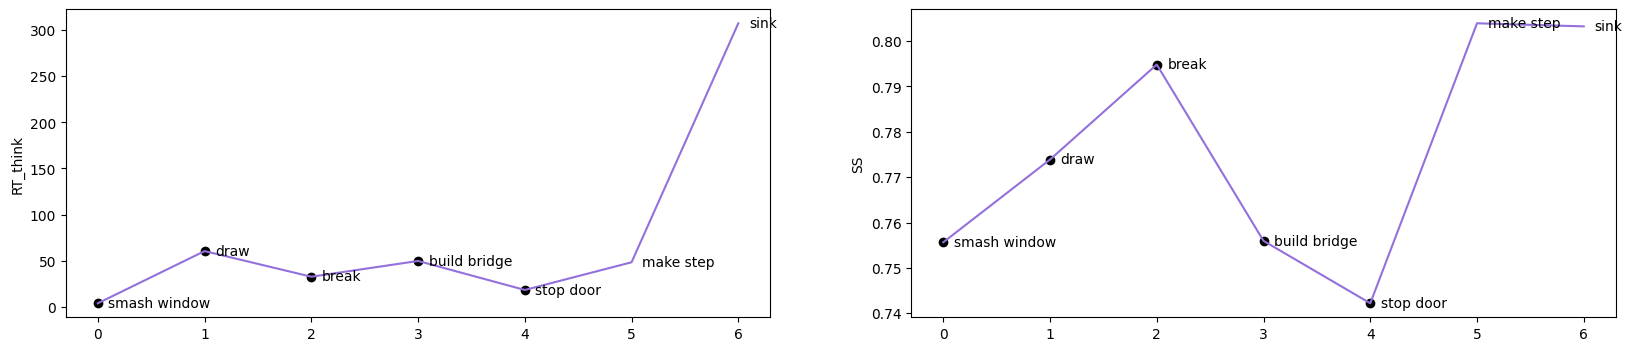

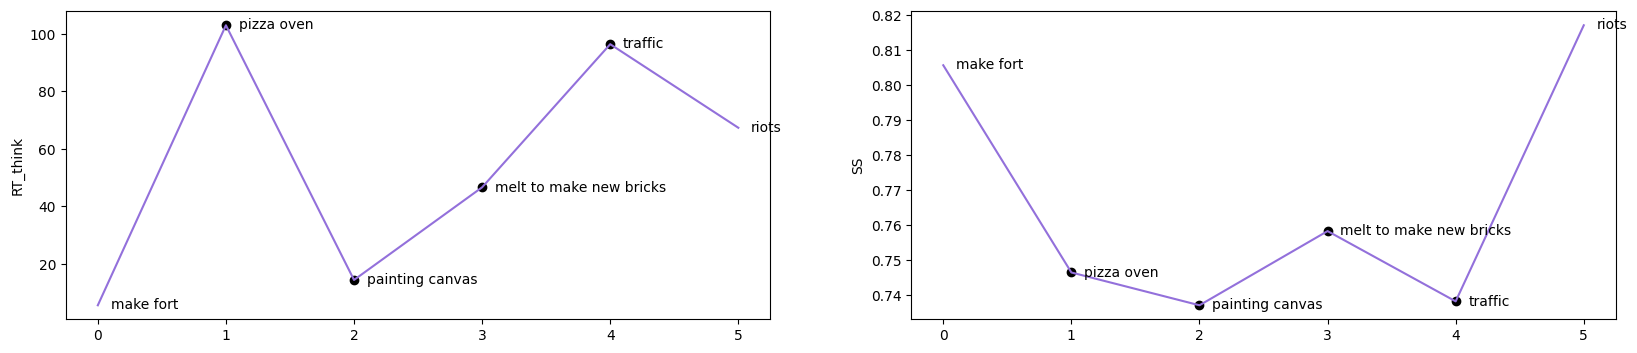

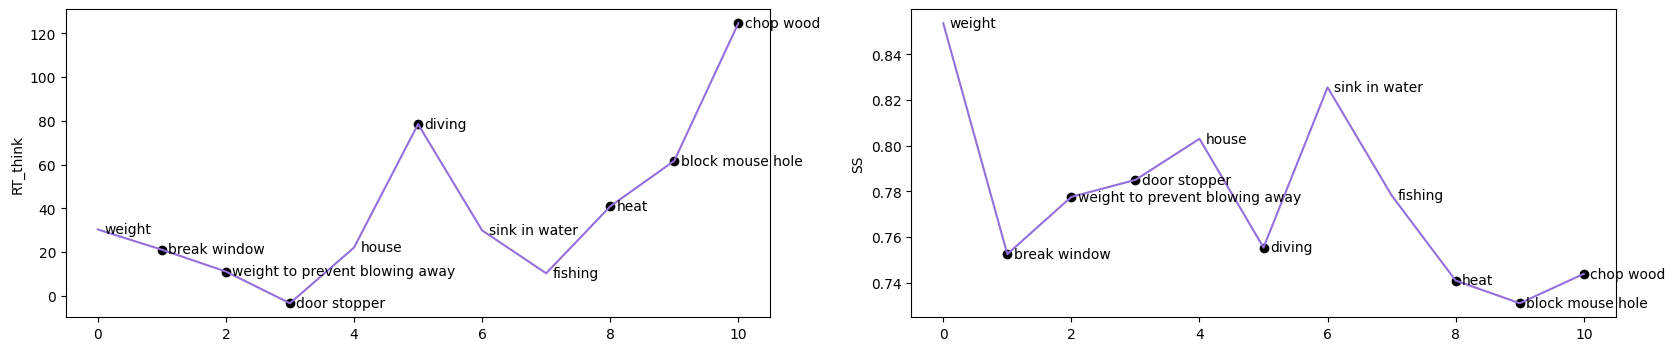

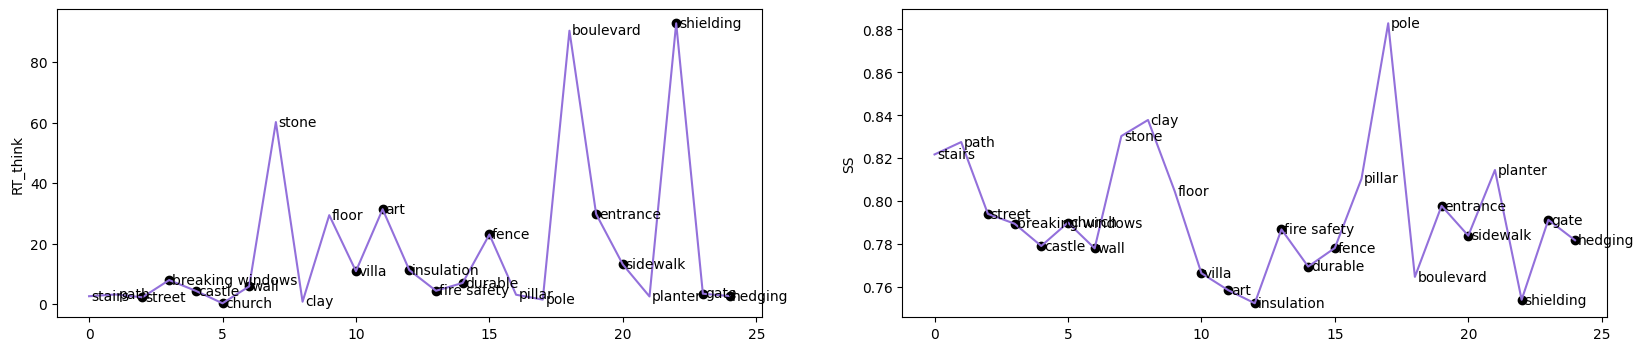

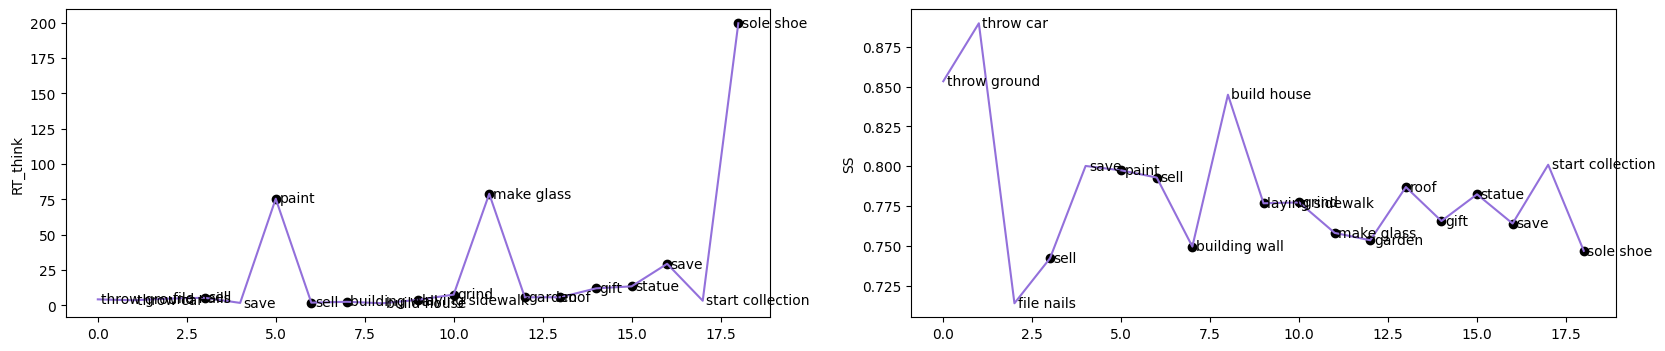

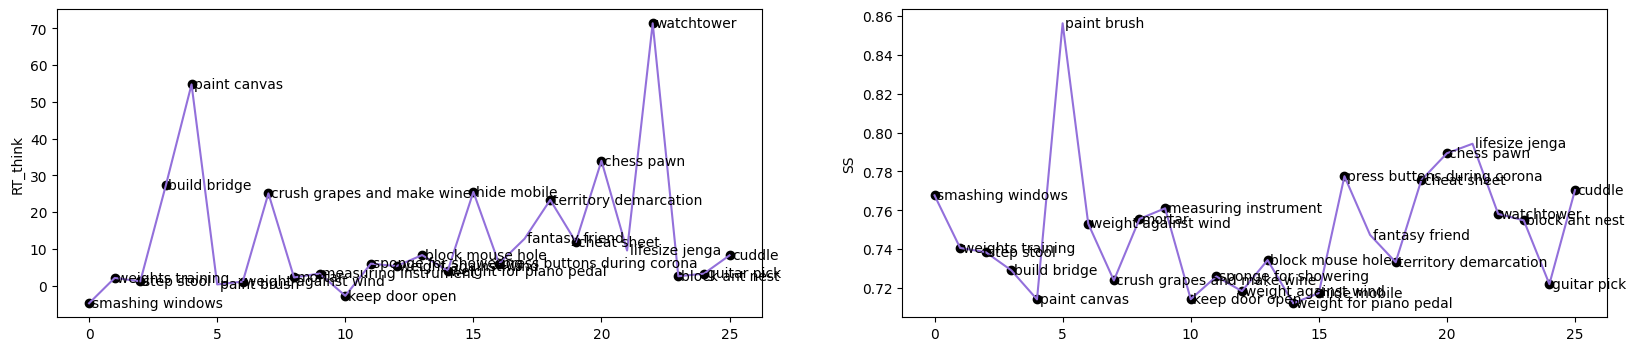

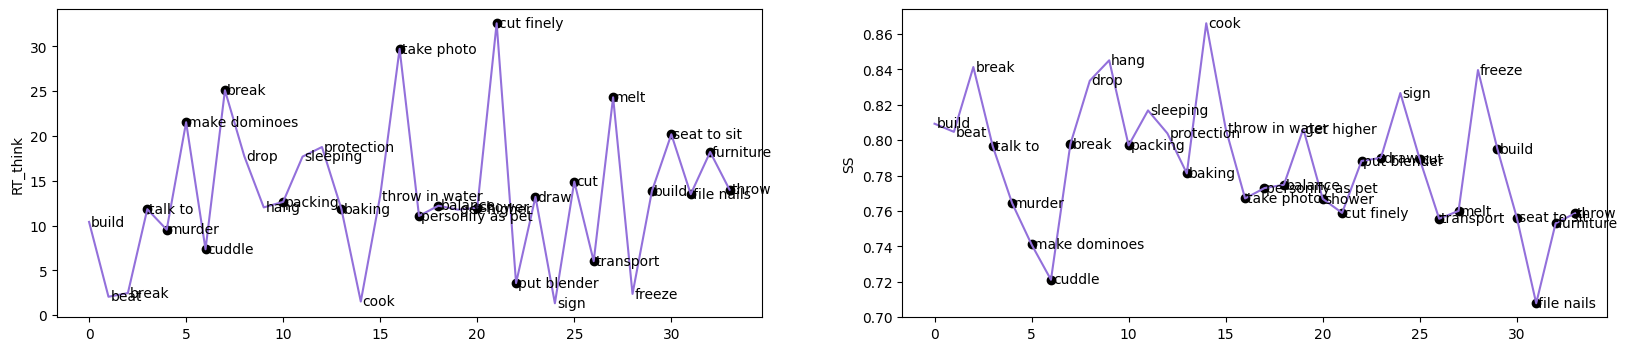

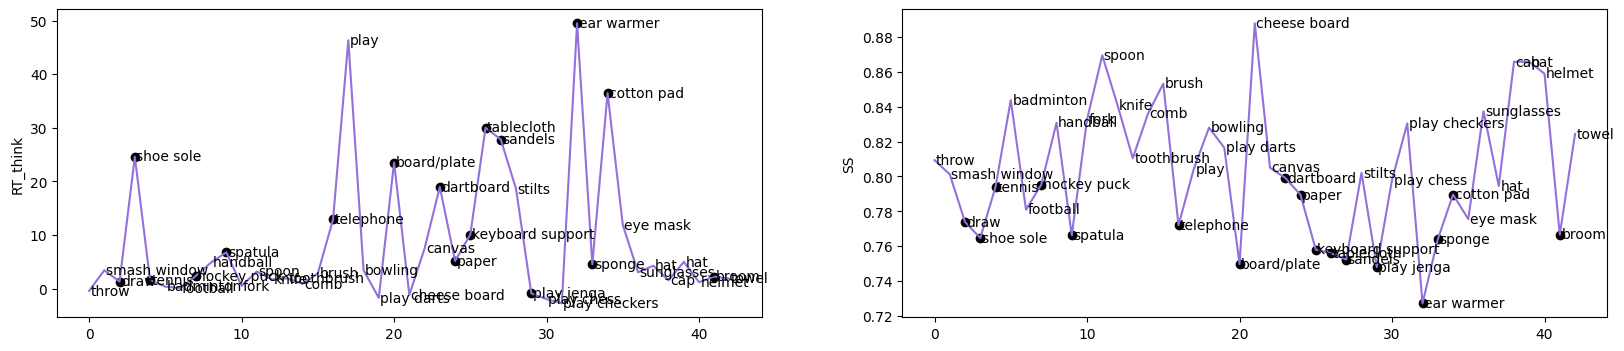

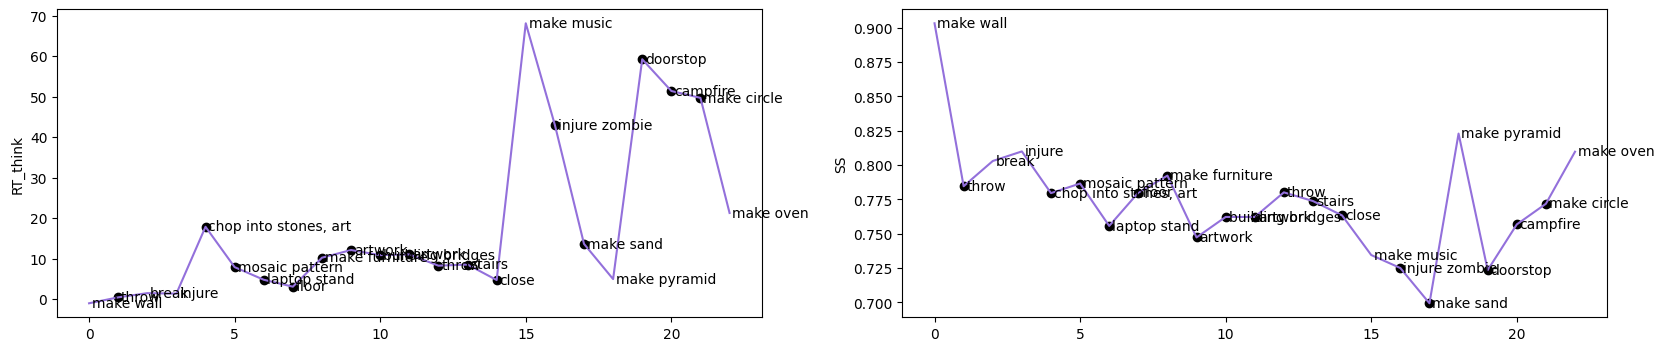

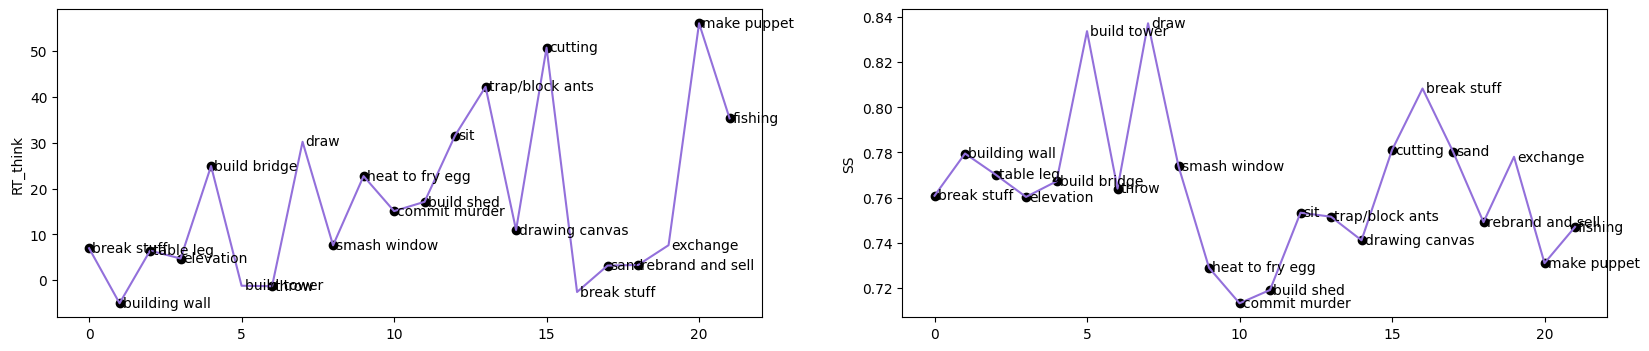

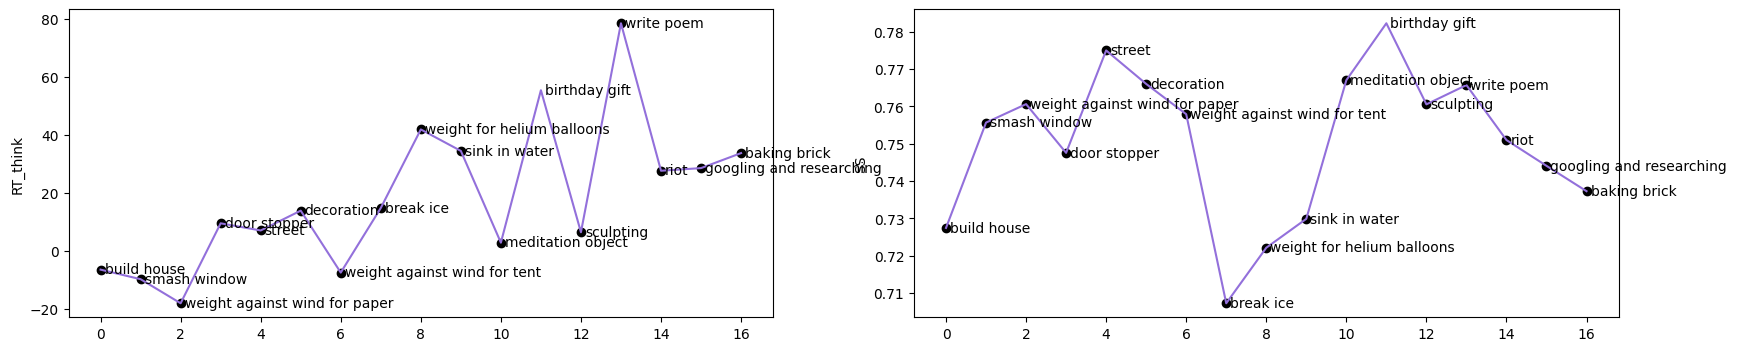

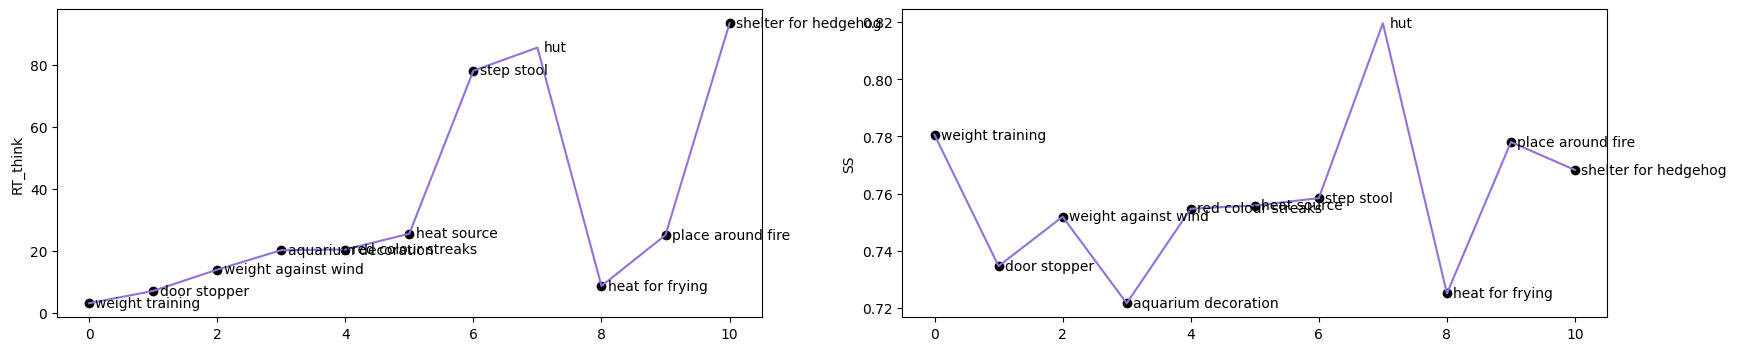

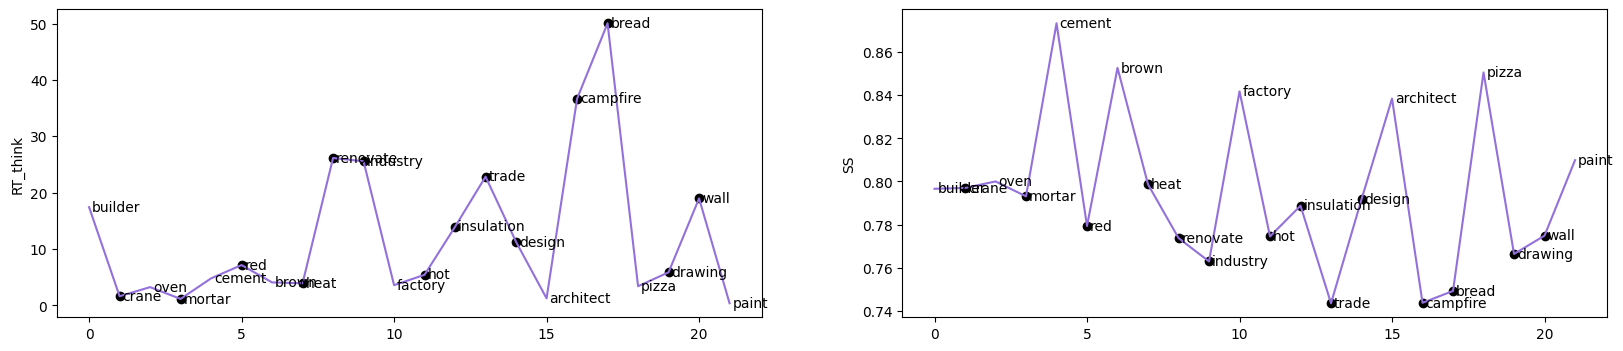

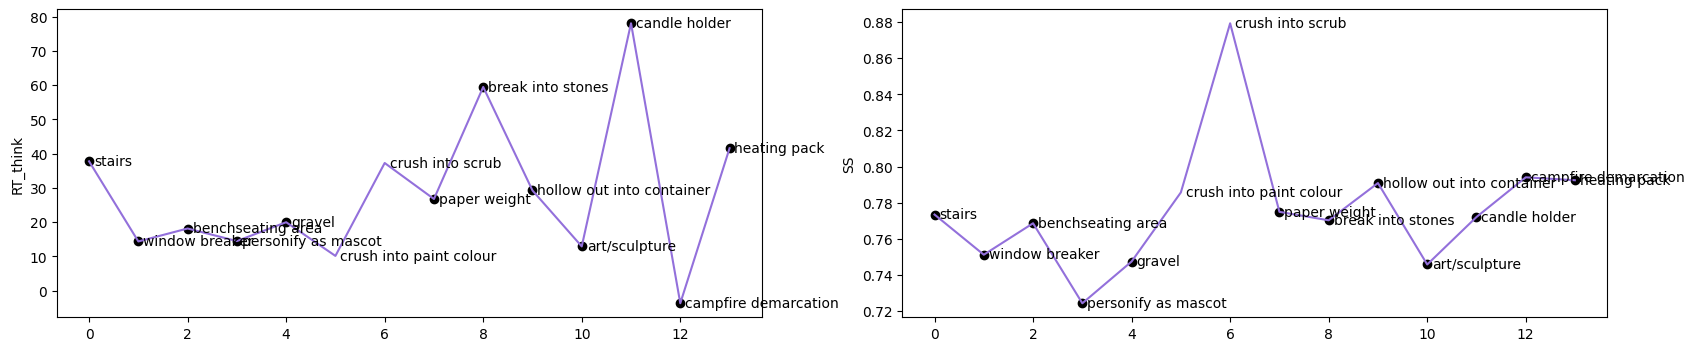

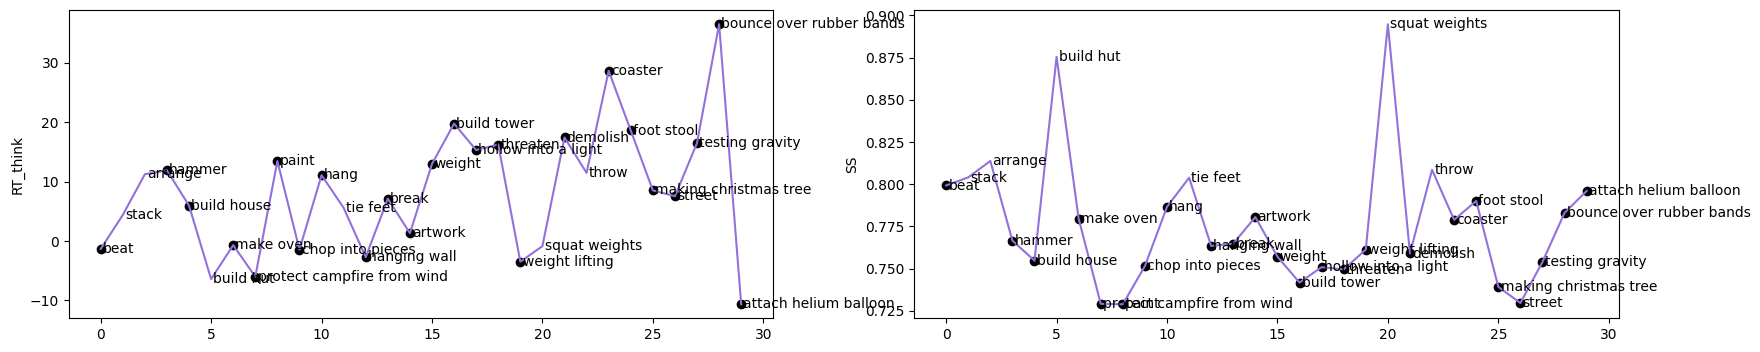

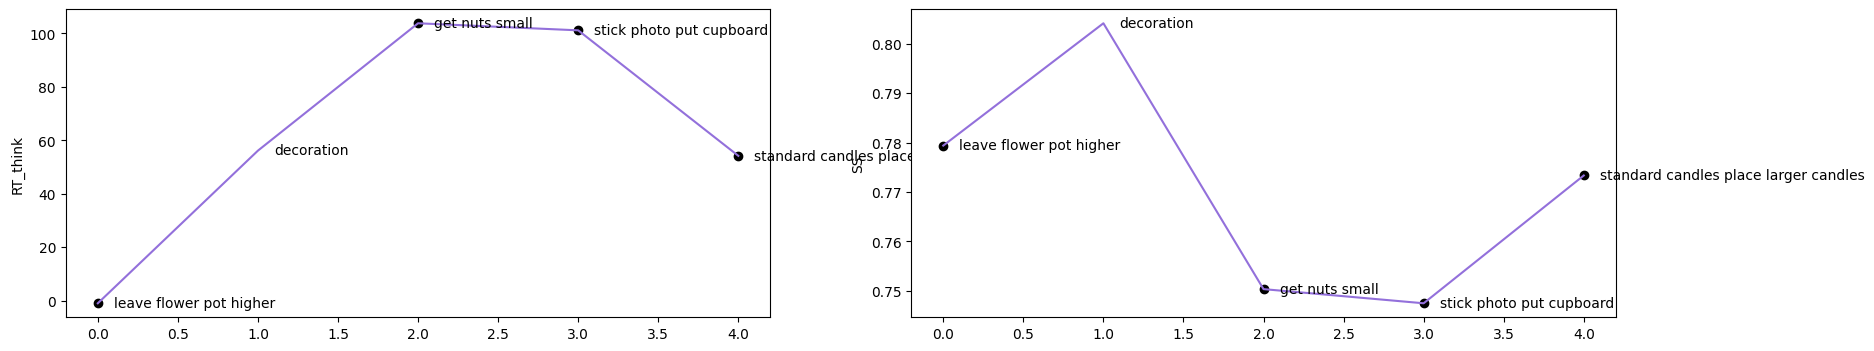

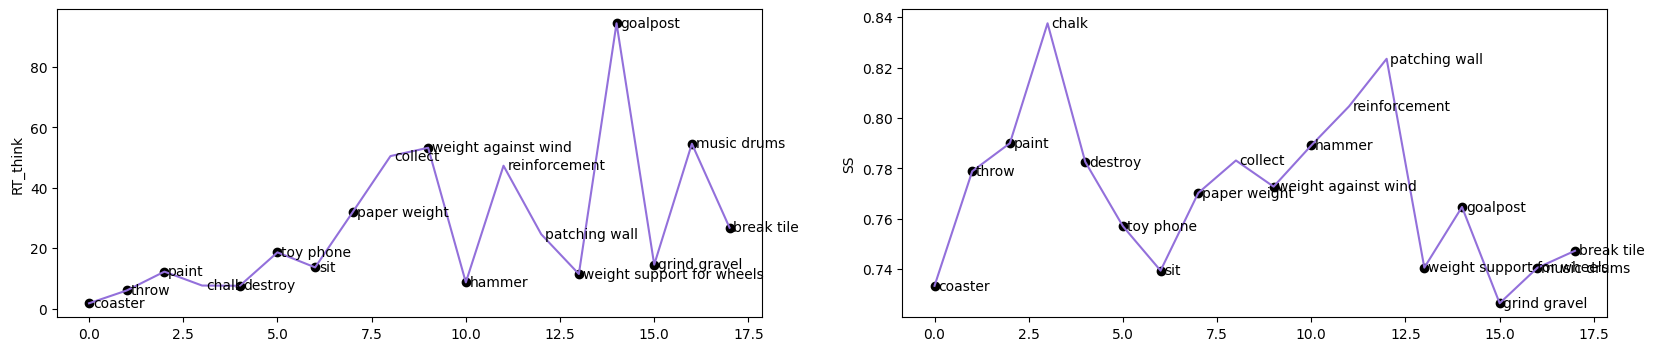

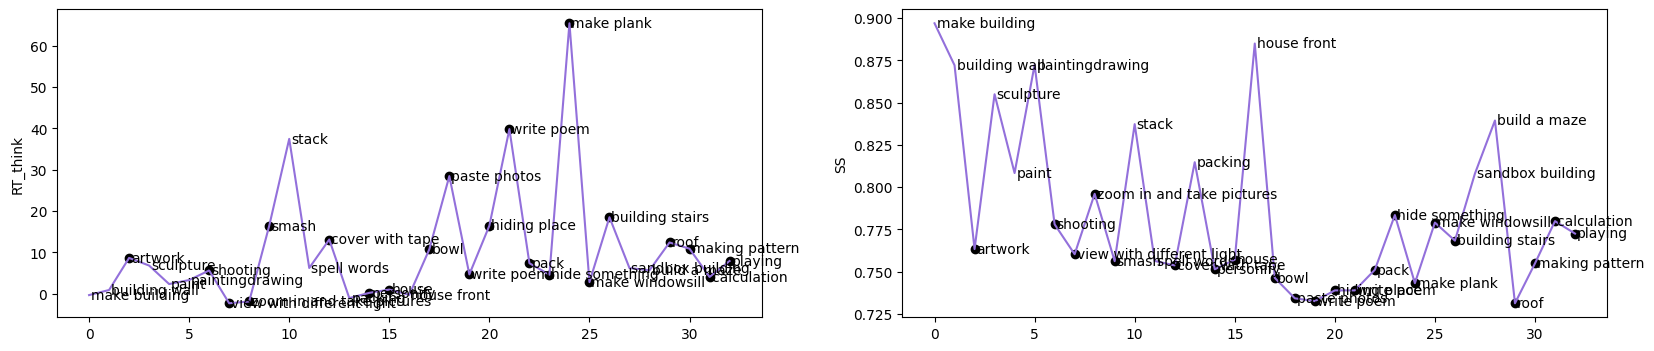

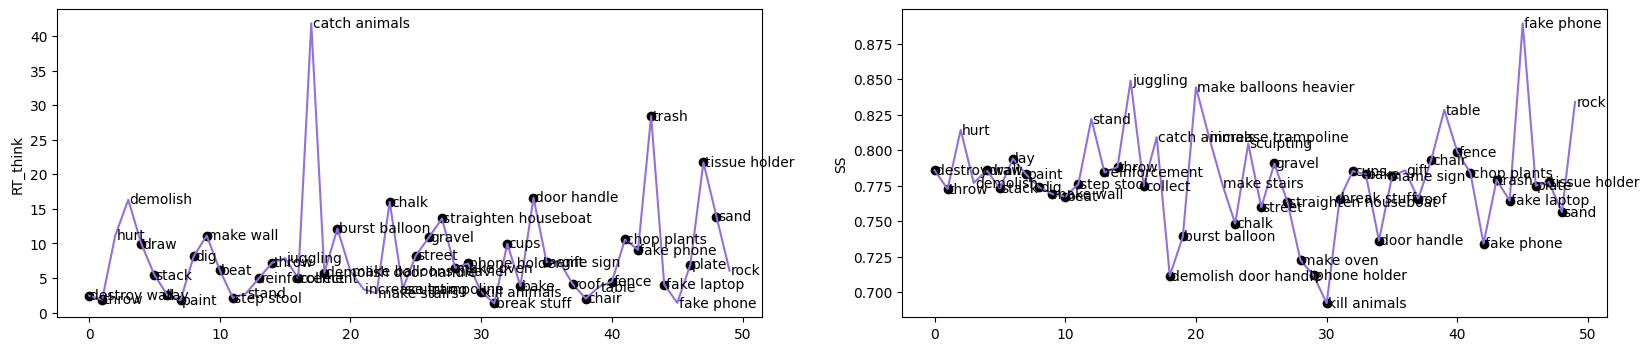

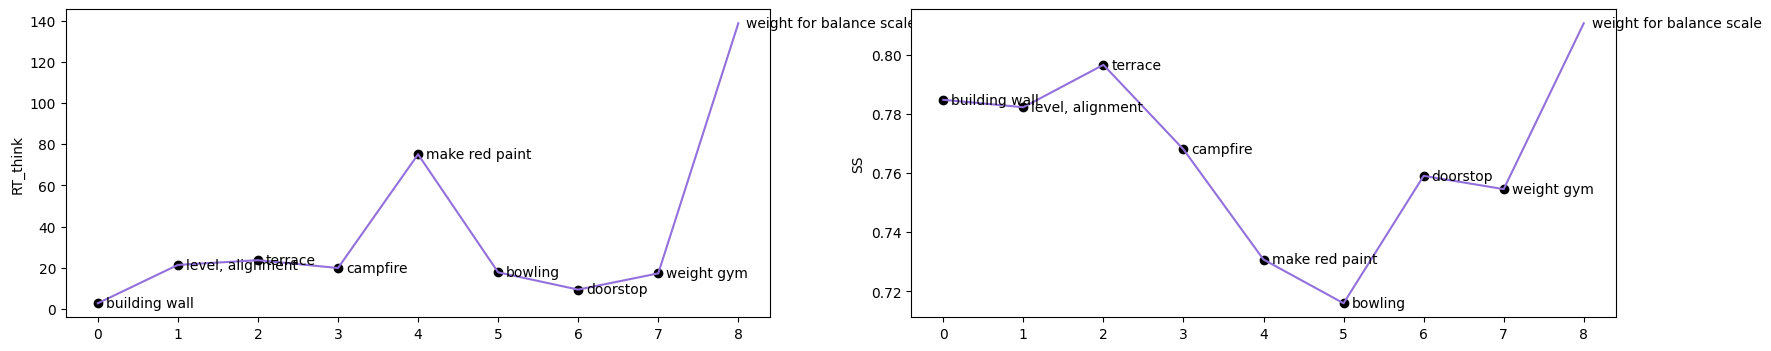

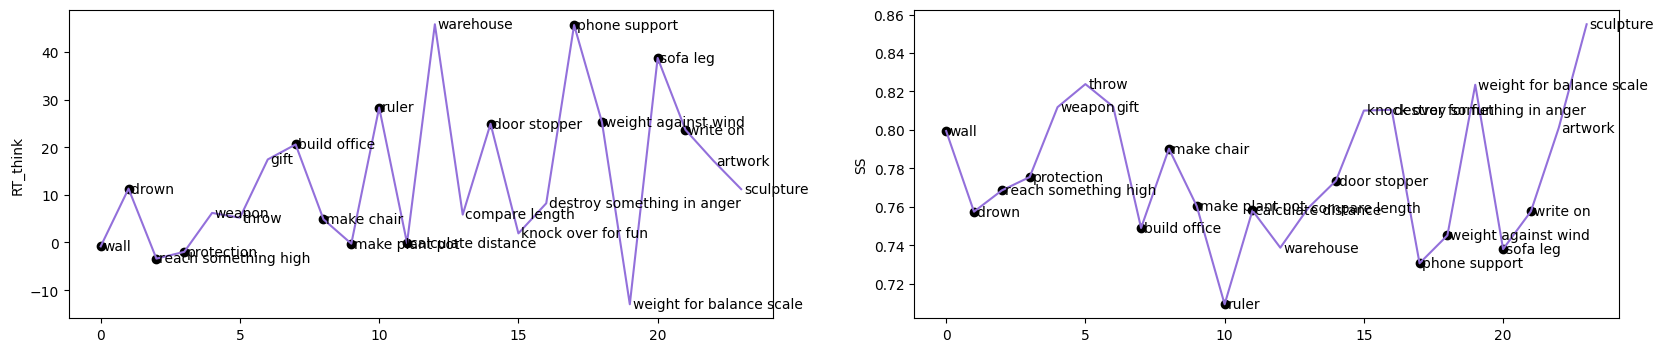

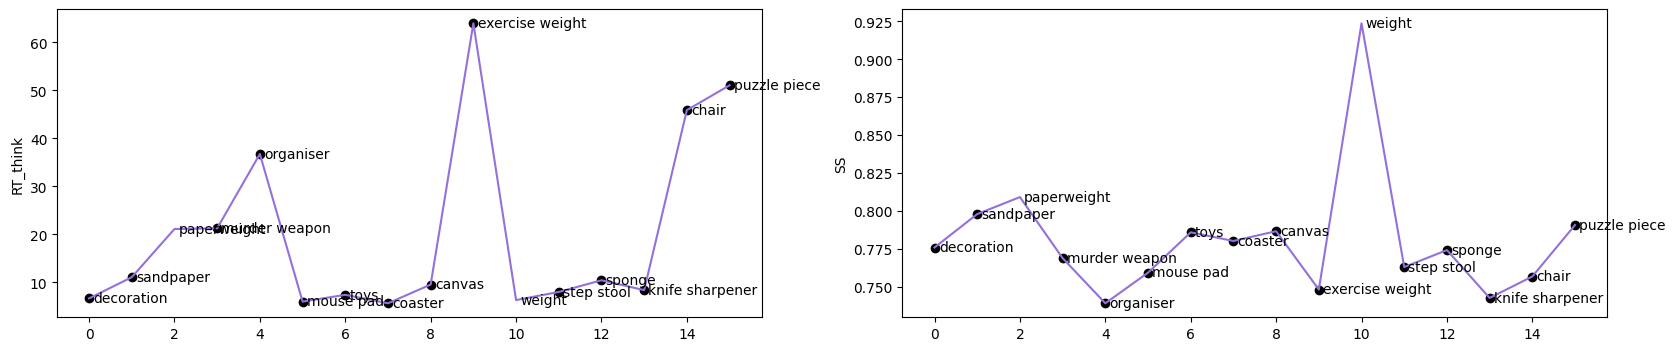

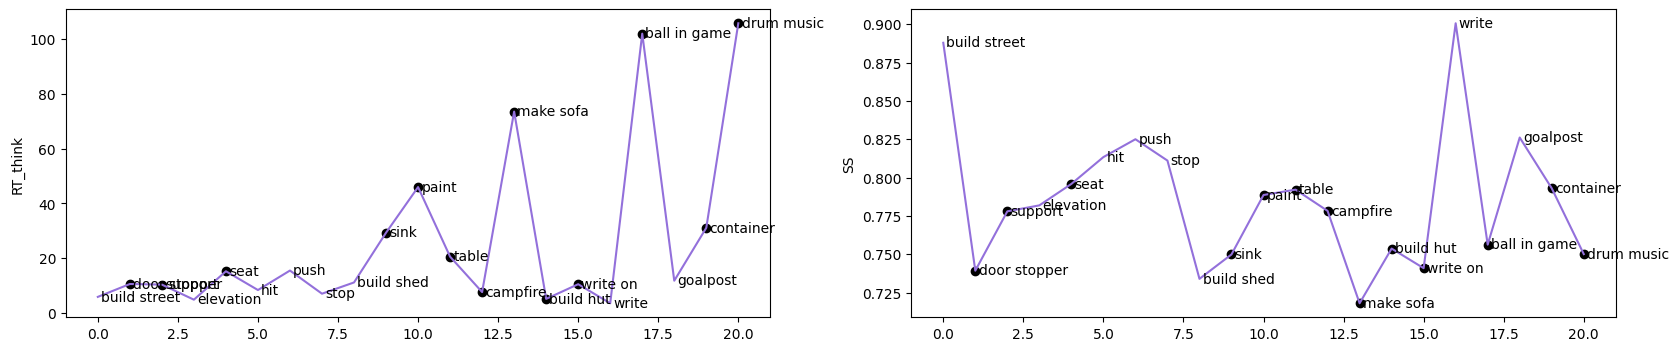

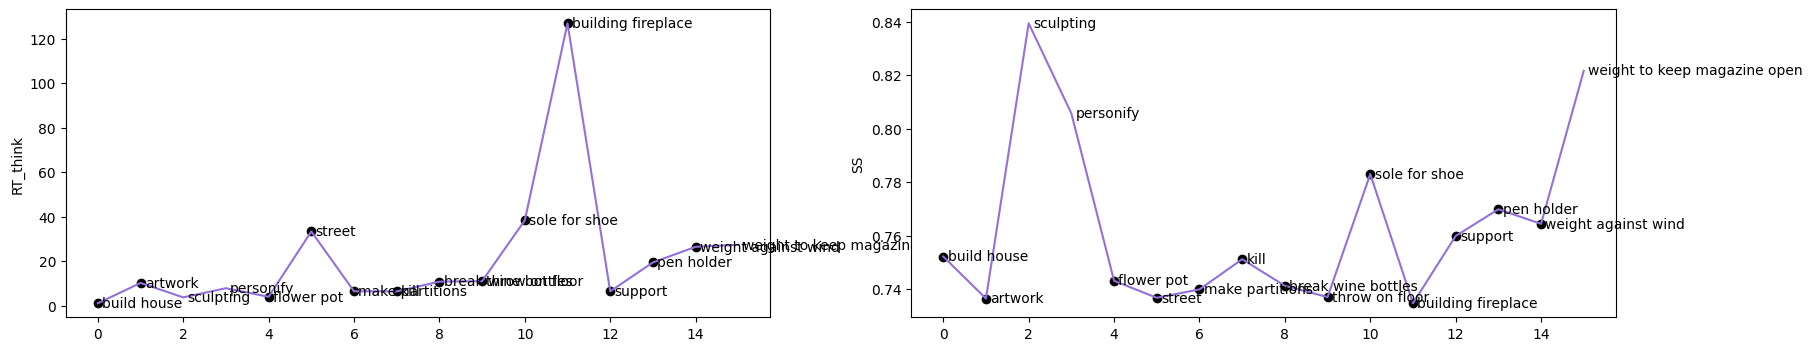

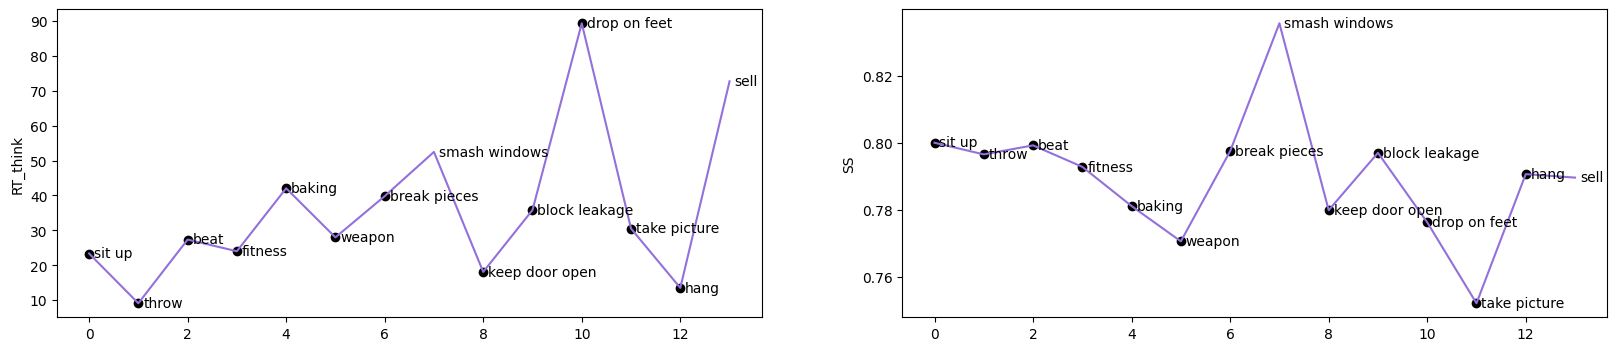

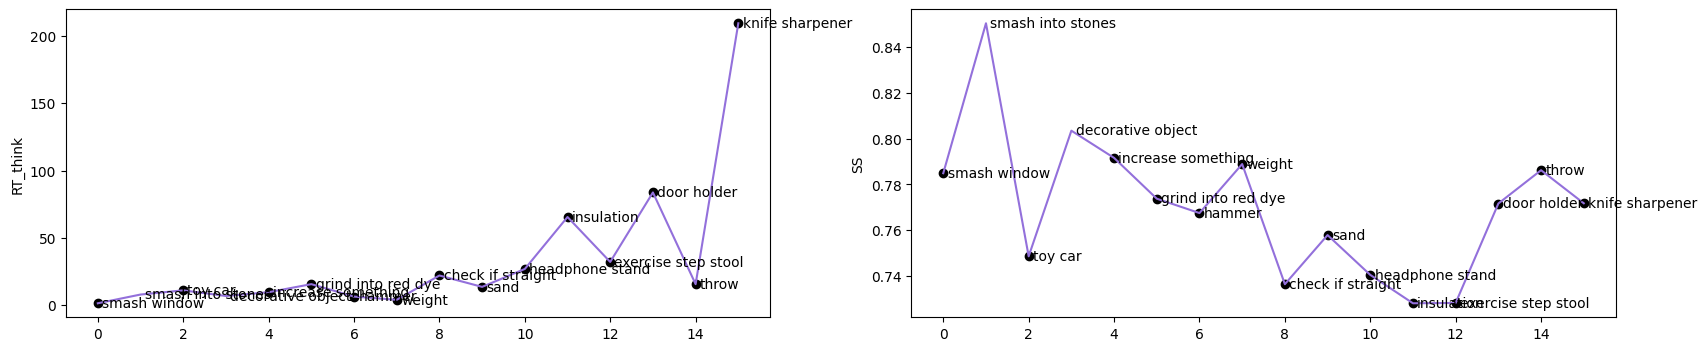

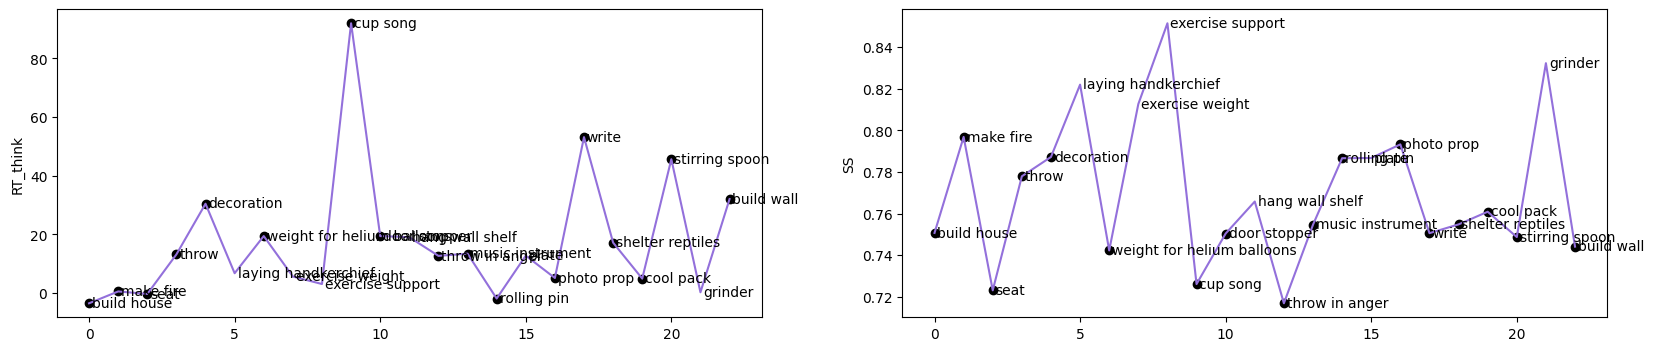

In [46]:
cnt = 0
for pid, (index, group) in enumerate(data_humans[data_humans["task"] == 2].groupby("pid").agg(list)[["RT_think", "SS", "jump", "response"]].iterrows()):
    group["RT_think"] = group["RT_think"][1:]
    group["SS"] = group["SS"][1:]
    group["jump"] = group["jump"][1:]
    group["response"] = group["response"][1:]

    if 0 in group["jump"]:
        # Plot RT values for the current group
        fig, ax = plt.subplots(1, 2, figsize=(20, 4))
        ax[0].plot(group["RT_think"], label=f'PID {pid}', linestyle='-', marker='', markersize=10, c="mediumpurple")
        # Check corresponding 'jump' values and plot scatter points where 'jump' is 1
        for i, (RT, jump) in enumerate(zip(group["RT_think"], group["jump"])):
            if jump == 1:
                ax[0].scatter(i, RT, color='black')  # Scatter plot on the markers
        for i, word in enumerate(group["response"]):
            ax[0].text(i + 0.1, group["RT_think"][i], word, ha='left', va='center')
        ax[0].set_ylabel("RT_think")

        ax[1].plot(group["SS"], label=f'PID {pid}', linestyle='-', marker='', markersize=10, c="mediumpurple")
        # Check corresponding 'jump' values and plot scatter points where 'jump' is 1
        for i, (SS, jump) in enumerate(zip(group["SS"], group["jump"])):
            if jump == 1:
                ax[1].scatter(i, SS, color='black')  # Scatter plot on the markers
        for i, word in enumerate(group["response"]):
            ax[1].text(i + 0.1, group["SS"][i], word, ha='left', va='center')
        ax[1].set_ylabel("SS")
        # ax[1].set_ylim(0,1)

        plt.show()
        cnt += 1
        if cnt == 30:
            break

# RT Clusters

In [47]:
data_humans["RT_jump"] = 1

def find_RT_cluster_indices(rts, tolerance=1):
    clusters = []
    current_cluster = [0]  # Start with the first RT
    for i in range(1, len(rts)):
        if abs(rts[i] - rts[i-1]) <= tolerance or rts[i] < rts[i-1]:
            current_cluster.append(i)
        else:
            if len(current_cluster) > 1:
                clusters.append(current_cluster)
            current_cluster = [i]
    if len(current_cluster) > 1:
        clusters.append(current_cluster)
    
    return clusters

for pid in data_humans[data_humans["task"] == 2]["pid"].unique(): 
    RT_list = data_humans[(data_humans["task"] == 2) & (data_humans["pid"] == pid)]["RT_think"].tolist()
    RT_clusters = find_RT_cluster_indices(RT_list)
    RT_jump = np.ones(len(data_humans[(data_humans["task"] == 2) & (data_humans["pid"] == pid)]))
    for item in RT_clusters:
        RT_jump[item[1:]] = 0
    data_humans.loc[(data_humans["pid"] == pid) & (data_humans["task"] == 2), "RT_jump"] = RT_jump

for pid in data_humans[data_humans["task"] == 3]["pid"].unique(): 
    RT_list = data_humans[(data_humans["task"] == 3) & (data_humans["pid"] == pid)]["RT_think"].tolist()
    RT_clusters = find_RT_cluster_indices(RT_list)
    RT_jump = np.ones(len(data_humans[(data_humans["task"] == 3) & (data_humans["pid"] == pid)]))
    for item in RT_clusters:
        RT_jump[item[1:]] = 0
    data_humans.loc[(data_humans["pid"] == pid) & (data_humans["task"] == 3), "RT_jump"] = RT_jump

for pid in data_humans[data_humans["task"] == 1]["pid"].unique(): 
    RT_list = data_humans[(data_humans["task"] == 1) & (data_humans["pid"] == pid)]["RT_think"].tolist()
    RT_clusters = find_RT_cluster_indices(RT_list)
    RT_jump = np.ones(len(data_humans[(data_humans["task"] == 1) & (data_humans["pid"] == pid)]))
    for item in RT_clusters:
        RT_jump[item[1:]] = 0
    data_humans.loc[(data_humans["pid"] == pid) & (data_humans["task"] == 1), "RT_jump"] = RT_jump

In [74]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data_humans[data_humans["task"] == 2]["jump"], data_humans[data_humans["task"] == 2]["RT_jump"])
TN, FP, FN, TP = cm.ravel()

# Calculate TPR, FPR, TNR, FNR
TPR = TP / (TP + FN)  # Sensitivity, Recall
FPR = FP / (FP + TN)
TNR = TN / (TN + FP)  # Specificity
FNR = FN / (TP + FN)

print(f"True Positive Rate (TPR): {TPR:.2f}")
print(f"True Negative Rate (TNR): {TNR:.2f}")
print(f"False Positive Rate (FPR): {FPR:.2f}")
print(f"False Negative Rate (FNR): {FNR:.2f}")

True Positive Rate (TPR): 0.55
True Negative Rate (TNR): 0.60
False Positive Rate (FPR): 0.40
False Negative Rate (FNR): 0.45


In [52]:
print(np.mean(data_humans[(data_humans["order"] > 0) & (data_humans["task"] == 2) & (data_humans["jump_cat"] == 0)]["RT_think"]),
np.mean(data_humans[(data_humans["order"] > 0) & (data_humans["task"] == 2) & (data_humans["jump_SS"] == 0)]["RT_think"]),
np.mean(data_humans[(data_humans["order"] > 0) & (data_humans["task"] == 2) & (data_humans["jump"] == 0)]["RT_think"]),
np.mean(data_humans[(data_humans["order"] > 0) & (data_humans["task"] == 2) & (data_humans["RT_jump"] == 0)]["RT_think"]),
)

print(np.mean(data_humans[(data_humans["order"] > 0) & (data_humans["task"] == 3) & (data_humans["jump_cat"] == 0)]["RT_think"]),
np.mean(data_humans[(data_humans["order"] > 0) & (data_humans["task"] == 3) & (data_humans["jump_SS"] == 0)]["RT_think"]),
np.mean(data_humans[(data_humans["order"] > 0) & (data_humans["task"] == 3) & (data_humans["jump"] == 0)]["RT_think"]),
np.mean(data_humans[(data_humans["order"] > 0) & (data_humans["task"] == 3) & (data_humans["RT_jump"] == 0)]["RT_think"]),
)

print(np.mean(data_humans[(data_humans["order"] > 0) & (data_humans["task"] == 1) & (data_humans["jump_cat"] == 0)]["RT_think"]),
np.mean(data_humans[(data_humans["order"] > 0) & (data_humans["task"] == 1) & (data_humans["jump_SS"] == 0)]["RT_think"]),
np.mean(data_humans[(data_humans["order"] > 0) & (data_humans["task"] == 1) & (data_humans["jump"] == 0)]["RT_think"]),
np.mean(data_humans[(data_humans["order"] > 0) & (data_humans["task"] == 1) & (data_humans["RT_jump"] == 0)]["RT_think"]),
)

14.583568798196472 12.573243487213357 14.410754956748445 8.358456053060326
13.024742864368898 13.888396389044907 14.648094745430527 7.67456317617593
0.20521570527255772 0.936118313843496 0.9627400571400725 0.14775024989132998


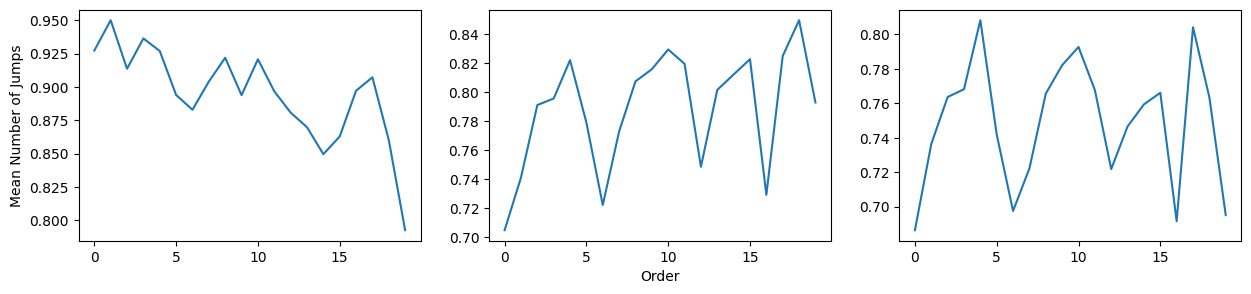

In [70]:
# proportion of switches across order

fig, ax = plt.subplots(1, 3, figsize=(15,3))
ax[0].plot(data_humans[(data_humans["order"] > 0) & (data_humans["task"] == 2)][["order", "jump_cat"]].groupby("order").mean()["jump_cat"].tolist()[0:20])
ax[0].set_ylabel("Mean Number of Jumps")
ax[1].plot(data_humans[(data_humans["order"] > 0) & (data_humans["task"] == 2)][["order", "jump_SS"]].groupby("order").mean()["jump_SS"].tolist()[0:20])
ax[1].set_xlabel("Order")
ax[2].plot(data_humans[(data_humans["order"] > 0) & (data_humans["task"] == 2)][["order", "jump"]].groupby("order").mean()["jump"].tolist()[0:20])

In [ ]:
import matplotlib.pyplot as plt

# Example list of cluster visits with consecutive clusters (e.g., 6, 6, 6)
cluster_visits = [3, 4, 5, 6, 6, 6, 3, 4, 1, 2]

# Function to generate random walk with circles around consecutive same clusters
def random_walk_with_circles(cluster_visits, cluster_sim_mat):
    positions = [(0, 0)]  # Start at the origin
    current_position = np.array([0, 0])  # Start position
    same_cluster_positions = []  # To store positions for consecutive clusters
    
    for i in range(1, len(cluster_visits)):
        current_cluster = cluster_visits[i-1]
        next_cluster = cluster_visits[i]
        
        # Get similarity from the matrix
        similarity = cluster_sim_mat[current_cluster, next_cluster]
        if similarity == 0:  # Handle edge case where similarity might be zero
            step_size = np.inf  # Handle division by zero
        else:
            step_size = 1 / similarity  # Larger similarity = smaller step size

        # Generate a random angle to determine direction
        random_angle = np.random.uniform(0, 2 * np.pi)
        
        # Determine the step direction in x and y
        step_vector = np.array([np.cos(random_angle), np.sin(random_angle)]) * step_size
        
        # Update current position
        current_position = current_position + step_vector
        positions.append(tuple(current_position))
        
        # Track consecutive clusters
        if current_cluster == next_cluster:
            same_cluster_positions.append(tuple(current_position))

    return positions, same_cluster_positions

# Generate the random walk and identify consecutive clusters
path, same_cluster_positions = random_walk_with_circles(cluster_visits, scaled_cluster_sim_mat_autbrick)

# Extract x and y coordinates from the positions
x_coords, y_coords = zip(*path)

# Plot the random walk
plt.figure(figsize=(8, 8))
plt.plot(x_coords, y_coords, marker='o', linestyle='-', markersize=5, color='blue')
plt.title("Random Walk with Circles Around Consecutive Same Clusters")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.grid(True)

# Draw circles around the points that belong to the same cluster consecutively
for pos in same_cluster_positions:
    circle = plt.Circle(pos, 0.5, color='red', fill=False, linestyle='--', linewidth=2)
    plt.gca().add_artist(circle)

plt.show()

In [ ]:
# cluster_means_autbrick = np.array([np.mean([sentence_transformer_embeddings_autbrick[resp] for resp in cluster_to_response_autbrick[i]], axis=0) for i in range(1, len(cluster_to_response_autbrick) + 1)])
# cluster_stds_autbrick = np.array([np.std([sentence_transformer_embeddings_autbrick[resp] for resp in cluster_to_response_autbrick[i]], axis=0) for i in range(1, len(cluster_to_response_autbrick) + 1)])

# cluster_means_autpaperclip = np.array([np.mean([sentence_transformer_embeddings_autpaperclip[resp] for resp in cluster_to_response_autpaperclip[i]], axis=0) for i in range(1, len(cluster_to_response_autpaperclip) + 1)])
# cluster_stds_autpaperclip = np.array([np.std([sentence_transformer_embeddings_autpaperclip[resp] for resp in cluster_to_response_autpaperclip[i]], axis=0) for i in range(1, len(cluster_to_response_autpaperclip) + 1)])

# cluster_means_vf = np.array([np.mean([sentence_transformer_embeddings_vf[resp] for resp in cluster_to_response_vf[i]], axis=0) for i in range(1, len(cluster_to_response_vf) + 1)])
# cluster_stds_vf = np.array([np.std([sentence_transformer_embeddings_vf[resp] for resp in cluster_to_response_vf[i]], axis=0) for i in range(1, len(cluster_to_response_vf) + 1)])

In [ ]:
boundary = 10

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(18,18))
k = 0

for pid, group in data_humans[data_humans["task"] == 2].groupby('pid'):
    if len(group) < 20:
        continue  
    
    try:

        vectors = np.array([sentence_transformer_embeddings_autbrick[resp] for resp in group["response"].values])
        aggregated = group.groupby("category").agg(list)
        # Filter out categories where the number of responses is greater than 1
        filtered_aggregated = aggregated[aggregated["response"].apply(len) > 1]
        single_points = np.array([np.mean([sentence_transformer_embeddings_autbrick[resp] for resp in l], axis=0) for l in filtered_aggregated["response"].values])
        radius = np.array([np.mean([sentence_transformer_embeddings_autbrick[resp] for resp in l], axis=0) for l in filtered_aggregated["response"].values])

        allvec = np.concatenate((vectors, single_points), axis = 0)

        pca = PCA(n_components=2)
        pca.fit(allvec)
        allvec = pca.transform(allvec)
        reduced_vectors = pca.transform(vectors)
        reduced_vectors_dict = dict(zip(group["response"].values, reduced_vectors))
        reduced_single_points = pca.transform(single_points)

        radius = np.array([np.max([np.sqrt(np.sum((reduced_vectors_dict[resp] - reduced_single_points[i]) ** 2)) for resp in l], axis=0) for i, l in enumerate(filtered_aggregated["response"].values)])

        # Normalize the reduced vectors and single points to fit within the range 0-boundary
        # x = boundary * (reduced_vectors[:, 0] - allvec[:, 0].min()) / (allvec[:, 0].max() - allvec[:, 0].min())
        # y = boundary * (reduced_vectors[:, 1] - allvec[:, 1].min()) / (allvec[:, 1].max() - allvec[:, 1].min())
        x = reduced_vectors[:, 0]
        y = reduced_vectors[:, 1]
        # single_x = boundary * (reduced_single_points[:, 0] - allvec[:, 0].min()) / (allvec[:, 0].max() - allvec[:, 0].min())
        # single_y = boundary * (reduced_single_points[:, 1] - allvec[:, 1].min()) / (allvec[:, 1].max() - allvec[:, 1].min())
        single_x = reduced_single_points[:, 0]
        single_y = reduced_single_points[:, 1]
        # radius = boundary * (radius) / (allvec[:, 0].max() - allvec[:, 0].min())

        # Choose a colormap
        cmap = get_cmap('viridis')
        colors = np.linspace(0, 1, len(x) - 1)
        for i in range(len(x) - 1):
            ax[k//5, k%5].plot([x[i], x[i+1]], [y[i], y[i+1]], color=cmap(colors[i]), marker='o')

        for i in range(len(single_x)):
            ax[k//5, k%5].plot(single_x[i], single_y[i], 'ro')  # Red point
            circle = Circle((single_x[i], single_y[i]), radius=radius[i], color='red', fill=False, linestyle='--')
            ax[k//5, k%5].add_patch(circle)
            
        # ax[k//5, k%5].set_xlabel('Component 1')
        # ax[k//5, k%5].set_ylabel('Component 2')
        # ax[k//5, k%5].set_xlim(0, boundary)
        # ax[k//5, k%5].set_ylim(0, boundary)
        k += 1
    
    except:
        continue

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(18,18))
k = 0
for pid, group in data_humans[data_humans["task"] == 3].groupby('pid'):
    if len(group) < 20:
        continue  
    
    try:

        vectors = np.array([sentence_transformer_embeddings_autpaperclip[resp] for resp in group["response"].values])
        aggregated = group.groupby("category").agg(list)
        # Filter out categories where the number of responses is greater than 1
        filtered_aggregated = aggregated[aggregated["response"].apply(len) > 1]
        single_points = np.array([np.mean([sentence_transformer_embeddings_autpaperclip[resp] for resp in l], axis=0) for l in filtered_aggregated["response"].values])

        allvec = np.concatenate((vectors, single_points), axis = 0)

        pca = PCA(n_components=2)
        pca.fit(allvec)
        allvec = pca.transform(allvec)
        reduced_vectors = pca.transform(vectors)
        reduced_vectors_dict = dict(zip(group["response"].values, reduced_vectors))
        reduced_single_points = pca.transform(single_points)

        radius = np.array([np.max([np.sqrt(np.sum((reduced_vectors_dict[resp] - reduced_single_points[i]) ** 2)) for resp in l], axis=0) for i, l in enumerate(filtered_aggregated["response"].values)])

        # Normalize the reduced vectors and single points to fit within the range 0-boundary
        # x = boundary * (reduced_vectors[:, 0] - allvec[:, 0].min()) / (allvec[:, 0].max() - allvec[:, 0].min())
        # y = boundary * (reduced_vectors[:, 1] - allvec[:, 1].min()) / (allvec[:, 1].max() - allvec[:, 1].min())
        x = reduced_vectors[:, 0]
        y = reduced_vectors[:, 1]
        # single_x = boundary * (reduced_single_points[:, 0] - allvec[:, 0].min()) / (allvec[:, 0].max() - allvec[:, 0].min())
        # single_y = boundary * (reduced_single_points[:, 1] - allvec[:, 1].min()) / (allvec[:, 1].max() - allvec[:, 1].min())
        single_x = reduced_single_points[:, 0]
        single_y = reduced_single_points[:, 1]
        # radius = boundary * (radius) / (allvec[:, 0].max() - allvec[:, 0].min())


        # Choose a colormap
        cmap = get_cmap('viridis')
        colors = np.linspace(0, 1, len(x) - 1)
        for i in range(len(x) - 1):
            ax[k//5, k%5].plot([x[i], x[i+1]], [y[i], y[i+1]], color=cmap(colors[i]), marker='o')

        for i in range(len(single_x)):
            ax[k//5, k%5].plot(single_x[i], single_y[i], 'ro')  # Red point
            circle = Circle((single_x[i], single_y[i]), radius=radius[i], color='red', fill=False, linestyle='--')
            ax[k//5, k%5].add_patch(circle)

        # ax[k//5, k%5].set_xlabel('Component 1')
        # ax[k//5, k%5].set_ylabel('Component 2')
        # ax[k//5, k%5].set_xlim(0, boundary)
        # ax[k//5, k%5].set_ylim(0, boundary)
        k += 1
    
    except:
        continue

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(18,18))
k = 0
for pid, group in data_humans[data_humans["task"] == 1].groupby('pid'):
    if len(group) < 20:
        continue  
    
    try:

        vectors = np.array([sentence_transformer_embeddings_vf[resp] for resp in group["response"].values])
        aggregated = group.groupby("category").agg(list)
        # Filter out categories where the number of responses is greater than 1
        filtered_aggregated = aggregated[aggregated["response"].apply(len) > 1]
        single_points = np.array([np.mean([sentence_transformer_embeddings_vf[resp] for resp in l], axis=0) for l in filtered_aggregated["response"].values])

        allvec = np.concatenate((vectors, single_points), axis = 0)

        pca = PCA(n_components=2)
        pca.fit(allvec)
        allvec = pca.transform(allvec)
        reduced_vectors = pca.transform(vectors)
        reduced_vectors_dict = dict(zip(group["response"].values, reduced_vectors))
        reduced_single_points = pca.transform(single_points)

        radius = np.array([np.max([np.sqrt(np.sum((reduced_vectors_dict[resp] - reduced_single_points[i]) ** 2)) for resp in l], axis=0) for i, l in enumerate(filtered_aggregated["response"].values)])

        # Normalize the reduced vectors and single points to fit within the range 0-boundary
        # x = boundary * (reduced_vectors[:, 0] - allvec[:, 0].min()) / (allvec[:, 0].max() - allvec[:, 0].min())
        # y = boundary * (reduced_vectors[:, 1] - allvec[:, 1].min()) / (allvec[:, 1].max() - allvec[:, 1].min())
        x = reduced_vectors[:, 0]
        y = reduced_vectors[:, 1]
        # single_x = boundary * (reduced_single_points[:, 0] - allvec[:, 0].min()) / (allvec[:, 0].max() - allvec[:, 0].min())
        # single_y = boundary * (reduced_single_points[:, 1] - allvec[:, 1].min()) / (allvec[:, 1].max() - allvec[:, 1].min())
        single_x = reduced_single_points[:, 0]
        single_y = reduced_single_points[:, 1]
        # radius = boundary * (radius) / (allvec[:, 0].max() - allvec[:, 0].min())

        # Choose a colormap
        cmap = get_cmap('viridis')
        colors = np.linspace(0, 1, len(x) - 1)
        for i in range(len(x) - 1):
            ax[k//5, k%5].plot([x[i], x[i+1]], [y[i], y[i+1]], color=cmap(colors[i]), marker='o')

        for i in range(len(single_x)):
            ax[k//5, k%5].plot(single_x[i], single_y[i], 'ro')  # Red point
            circle = Circle((single_x[i], single_y[i]), radius=radius[i], color='red', fill=False, linestyle='--')
            ax[k//5, k%5].add_patch(circle)

        # ax[k//5, k%5].set_xlabel('Component 1')
        # ax[k//5, k%5].set_ylabel('Component 2')
        # ax[k//5, k%5].set_xlim(0, boundary)
        # ax[k//5, k%5].set_ylim(0, boundary)
        k += 1
    
    except:
        continue

plt.tight_layout()
plt.show()

## Structure in Going Back?